В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде __класифікувати__ товари із датасету `fasion_mnist`.

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно __91%__. Точність вашої моделі повинна бути `не нижчою` за цей показник. Щоб досягти таких значень вам знадобиться `поекспериментувати з гіперпараметрами мережі`:

- кількість шарів;

- кількість нейронів;

- функції активації;

- кількість епох;

- розмір батчу;

- вибір оптимізатора;

- різні техніки регуляризації і т.д.

Використайте вивчені `техніки виявлення проблем навчання` нейронної мережі, і потім `поекспериментуйте`.

Рішення оформіть у вигляді окремого ноутбука.

In [65]:
import itertools
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.datasets import fashion_mnist
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras import metrics
from keras import optimizers


### __Dataset__

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.dtype, x_train[0].shape

(dtype('uint8'), (28, 28))

In [6]:
NUM_FEATURES = x_train[0].shape[0] * x_train[0].shape[1]

In [7]:
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# each sample (28x28) to 1x784
x_train, x_test = x_train.reshape([-1, NUM_FEATURES]), x_test.reshape([-1, NUM_FEATURES])
print(min(x_train.min(), x_test.min()))
maximum = max(x_train.max(), x_test.max()) # np.max([x_train.max(), x_test.max()]) 
maximum

0.0


255.0

In [8]:
# Normalize (min = 0)
x_train, x_test = x_train / maximum, x_test / maximum

In [9]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [10]:
max(y_train.max(), y_test.max()), min(y_train.min(), y_test.min())

(9, 0)

In [11]:
NUM_CLASSES = len(set(np.concatenate((y_train, y_test), axis=0)))
NUM_CLASSES

10

In [12]:
y_true = tf.one_hot(y_train, depth=NUM_CLASSES).numpy()
y_truev = tf.one_hot(y_test, depth=NUM_CLASSES).numpy()
y_true.shape, y_truev.shape

((60000, 10), (10000, 10))

### __Model__

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

In [13]:
# number of hidden layers
n_layers = [el for el in range(1, 3)]  # 1, 2
n_of_neurons = [2**el for el in range(1, 8)] # [[2**el for el in range(1, 9)] for _ in n_layers]  # 7

activations = ['relu', 'sigmoid', 'softmax']  # 'mish',

optimizators = [optimizers.legacy.SGD, optimizers.legacy.RMSprop, optimizers.legacy.Adam]  # 3
learning_rates = [10**el for el in range(-3, -1)]  # 2
n_epoch = 100  # max limit
batch_sizes = [2**el for el in range(7, 10)]  # 3



In [14]:
n_hiddens_ = []  # list of different (by number) layers for different models
bundle_activations  = []  # list of various feature sets of activations of all layers for different models
for s in n_layers:
    for el in list(itertools.product(n_of_neurons, repeat=s)):
        n_hidden_i = []
        n_hidden_i.append(NUM_FEATURES)
        n_hidden_i.extend(el)
        n_hidden_i.append(NUM_CLASSES)

        n_hiddens_.append(n_hidden_i)

    for el in list(itertools.product(activations[:-1], repeat=s)):
        activat = []
        activat.extend(el)
        activat.append(activations[-1])

        bundle_activations.append(activat)
    

In [15]:
len(n_hiddens_), len(bundle_activations)

(56, 6)

In [16]:
# matching layers with models
cx = 0  # number of options
for set_layers in n_hiddens_:  # 584
    for act in bundle_activations:  # 39
        if len(set_layers) == (len(act) + 1):
            cx+=1

cx

210

In [17]:
def create_NN(n_hidden_: list, activation: list, optimizer=optimizers.SGD, learning_rate=0.1) -> Sequential:
    model = Sequential(name=f'''m-{''.join(map(str, [f'{i}-' for i in n_hidden_[1:-1]]))}{''.join(map(str, [f'{a}-' for a in activation[:-1]]))}{optimizer.__name__}-{learning_rate}''')
    n_layers = len(n_hidden_)
    for layer in range(1, n_layers):
        model.add(Dense(n_hidden_[layer], activation=activation[layer-1], input_shape=(n_hidden_[layer-1],)))

    model.compile(
                  optimizer=optimizer(learning_rate=learning_rate), # legacy
                  loss=losses.CategoricalCrossentropy(),  # 'categorical_crossentropy' losses.binary_crossentropy,
                  metrics=['accuracy', metrics.CategoricalAccuracy()]  # metrics.BinaryAccuracy()  CategoricalAccuracy()
                  )

    return model

In [18]:
models = []  # 9216 models # !!! more then 32 GB RAM!!!!, ... try 1260 = 28sec
for set_layers in n_hiddens_:  # 584
    for act in bundle_activations:  # 39
        if len(set_layers) == (len(act) + 1):  # 1024  -> 210
            for opt in optimizators:  # 3
                for lr in learning_rates:  # 2
                    models.append(create_NN(n_hidden_=set_layers, activation=act, optimizer=opt, learning_rate=lr))

In [19]:
models[0].name  # model(m)-n_layer_1-...-activ_fun_layer_1-...-optimizator-learning_rate:

'm-2-relu-SGD-0.001'

### __Training__

In [20]:
history = {}  # 27648 = 38+ days training
lucky_numbers = np.random.randint(1, len(models), size=5)
for num, model in enumerate(models):
    if num in lucky_numbers:
        for bs in batch_sizes:  # 3
            history[f'{model.name}({bs})'] = model.fit(
                                                        x_train,
                                                        y_true,
                                                        epochs=100,
                                                        batch_size=bs,
                                                        validation_data=(x_test, y_truev)
                                                        )

Epoch 1/100
469/469 [==============================] - 1s 2ms/step - loss: 2.1482 - accuracy: 0.2293 - categorical_accuracy: 0.2293 - val_loss: 2.0087 - val_accuracy: 0.2721 - val_categorical_accuracy: 0.2721
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 1.8821 - accuracy: 0.2835 - categorical_accuracy: 0.2835 - val_loss: 1.7908 - val_accuracy: 0.2869 - val_categorical_accuracy: 0.2869
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 1.7141 - accuracy: 0.2962 - categorical_accuracy: 0.2962 - val_loss: 1.6321 - val_accuracy: 0.3195 - val_categorical_accuracy: 0.3195
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 1.5454 - accuracy: 0.3683 - categorical_accuracy: 0.3683 - val_loss: 1.4489 - val_accuracy: 0.4326 - val_categorical_accuracy: 0.4326
Epoch 5/100
469/469 [==============================] - 1s 2ms/step - loss: 1.3413 - accuracy: 0.4669 - categorical_accuracy: 0.4669 - val_loss: 1.2852 - val_accurac

### __Error Analysis__

In [21]:
# print(history[0].history.keys())
""" 
loss - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи
val_loss - список, де зберігається історія змін помилки на тестових даних залежно від епохи
accuracy - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи
val_accuracy - список, де зберігається історія змін точності на тестових даних залежно від епохи
"""

' \nloss - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи\nval_loss - список, де зберігається історія змін помилки на тестових даних залежно від епохи\naccuracy - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи\nval_accuracy - список, де зберігається історія змін точності на тестових даних залежно від епохи\n'

In [22]:
def draw_2twin_2d(y00: np.array, y01: np.array, y10: np.array, y11: np.array, suptitle: str) -> None:
    x = range(1, len(y00) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    axs[0].plot(x, y00, 'bo', label='Training loss')
    axs[0].plot(x, y01, 'g', label='Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y10, 'bo', label='Training acc')
    axs[1].plot(x, y11, 'g', label='Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    axs[1].grid()
    plt.show()


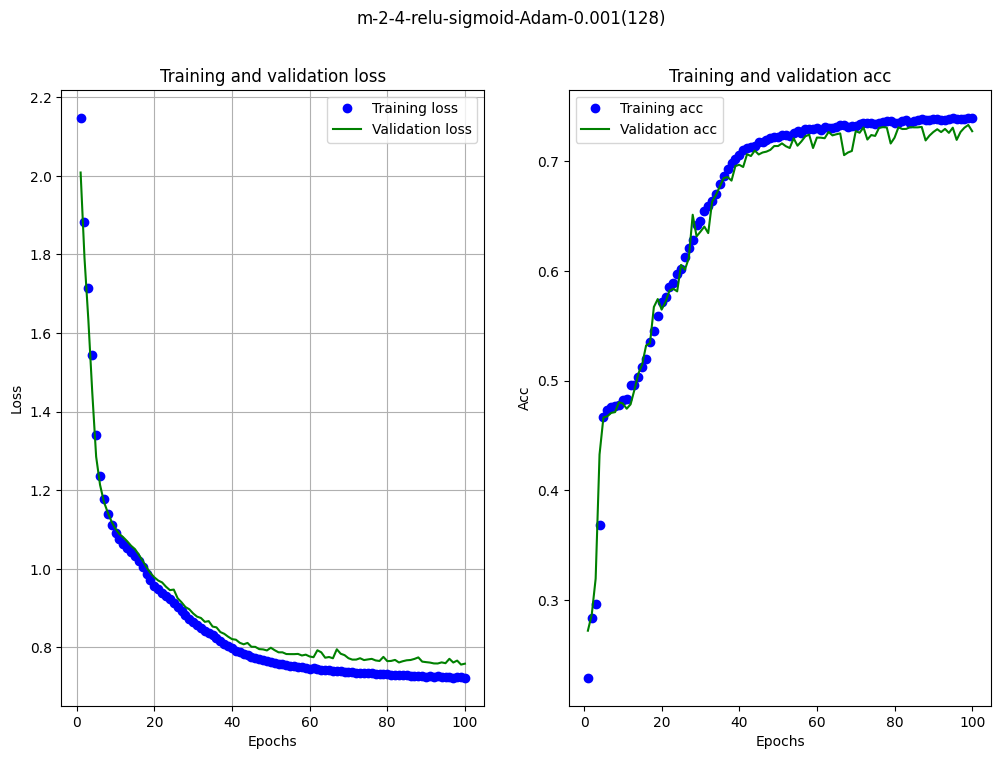

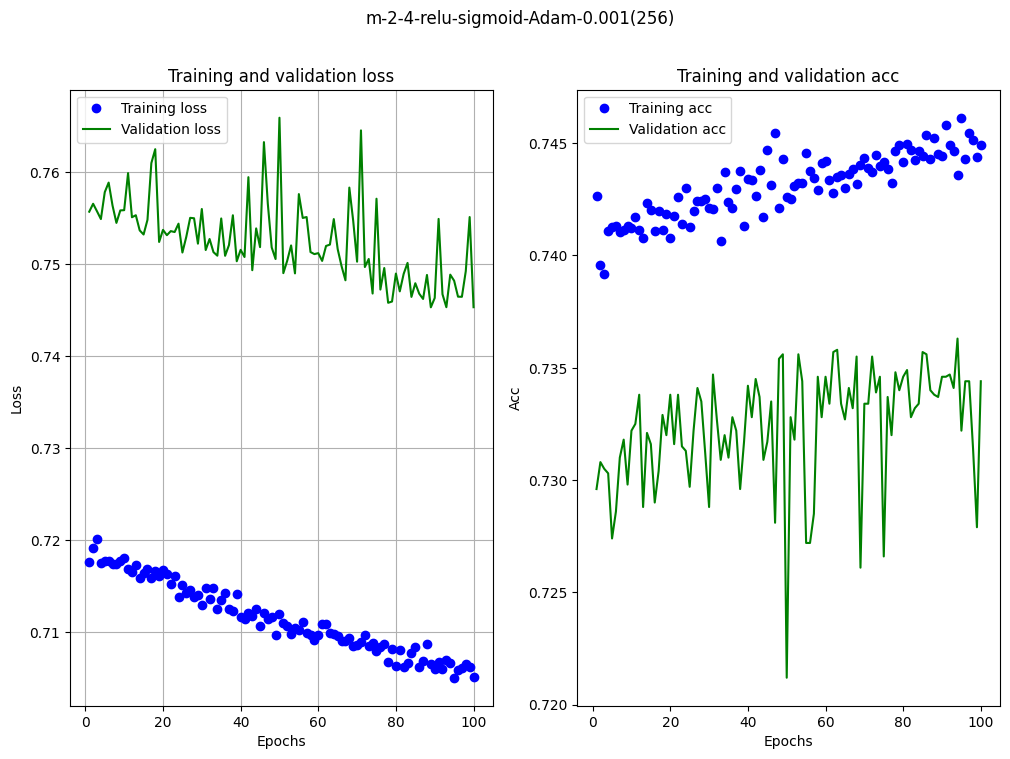

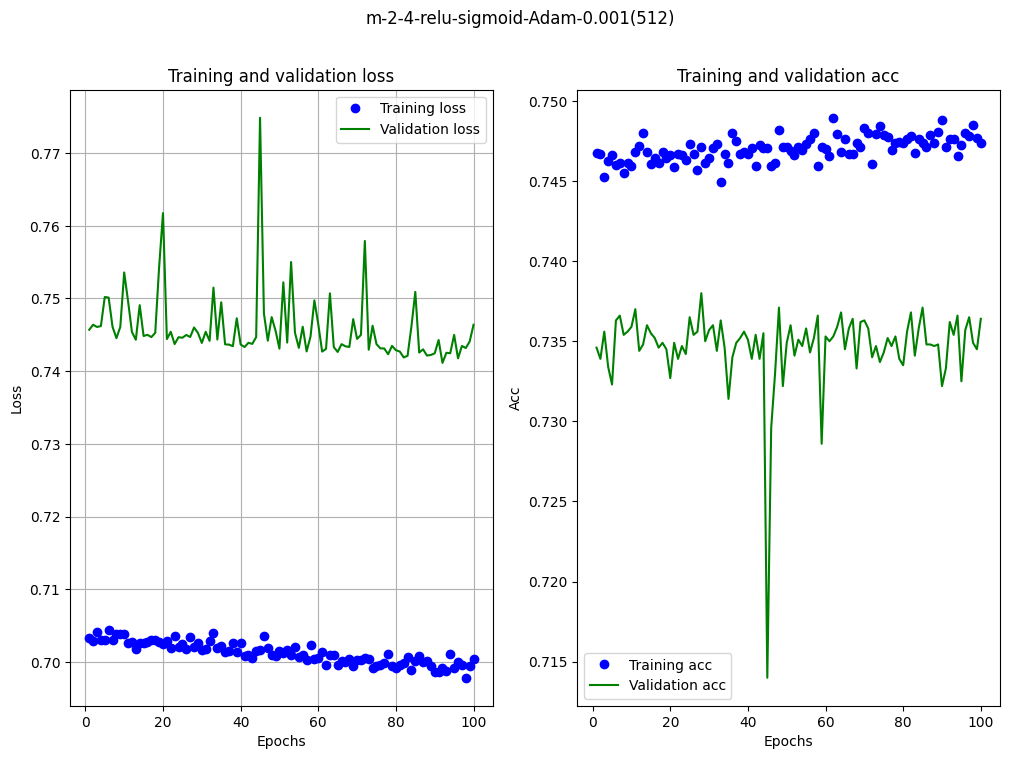

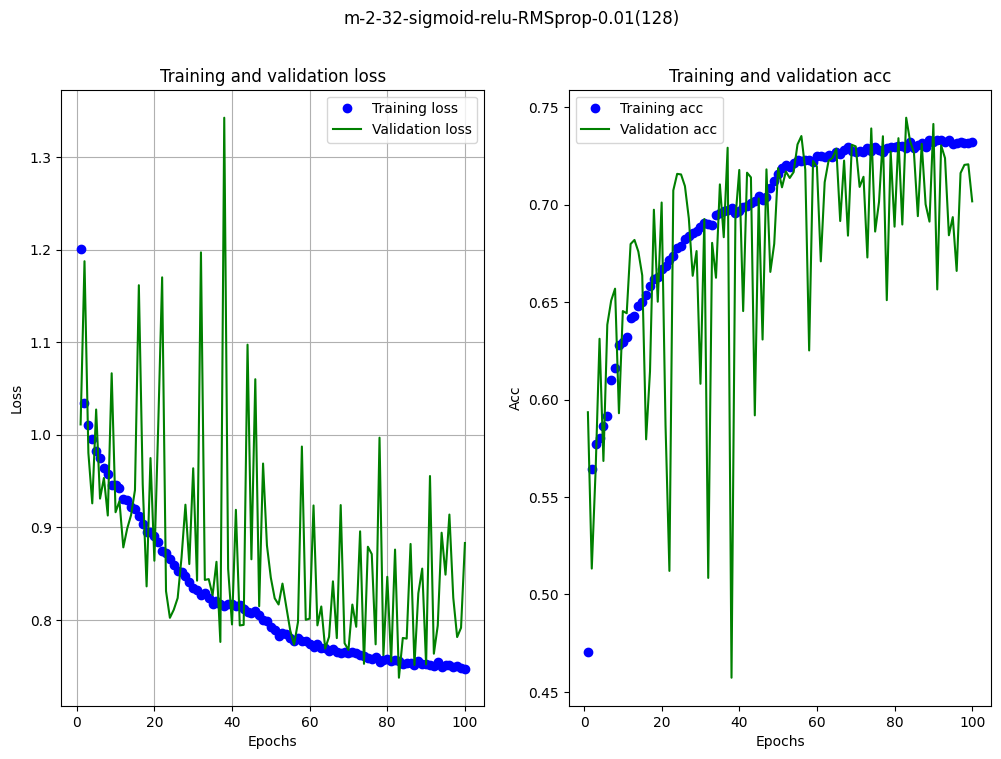

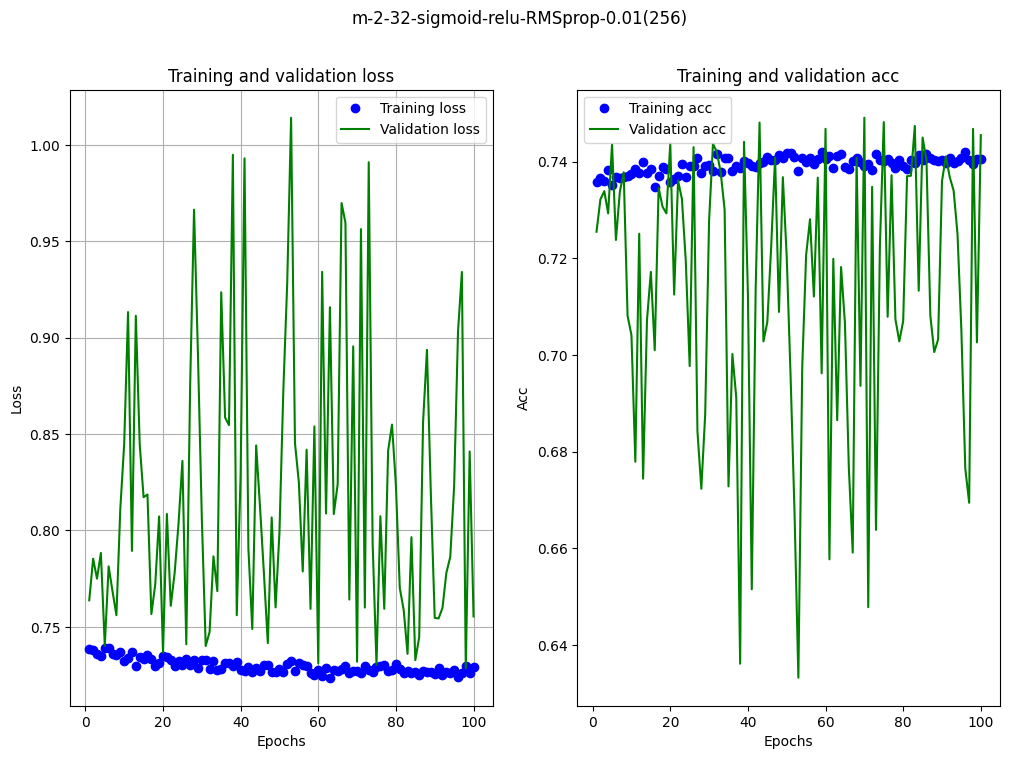

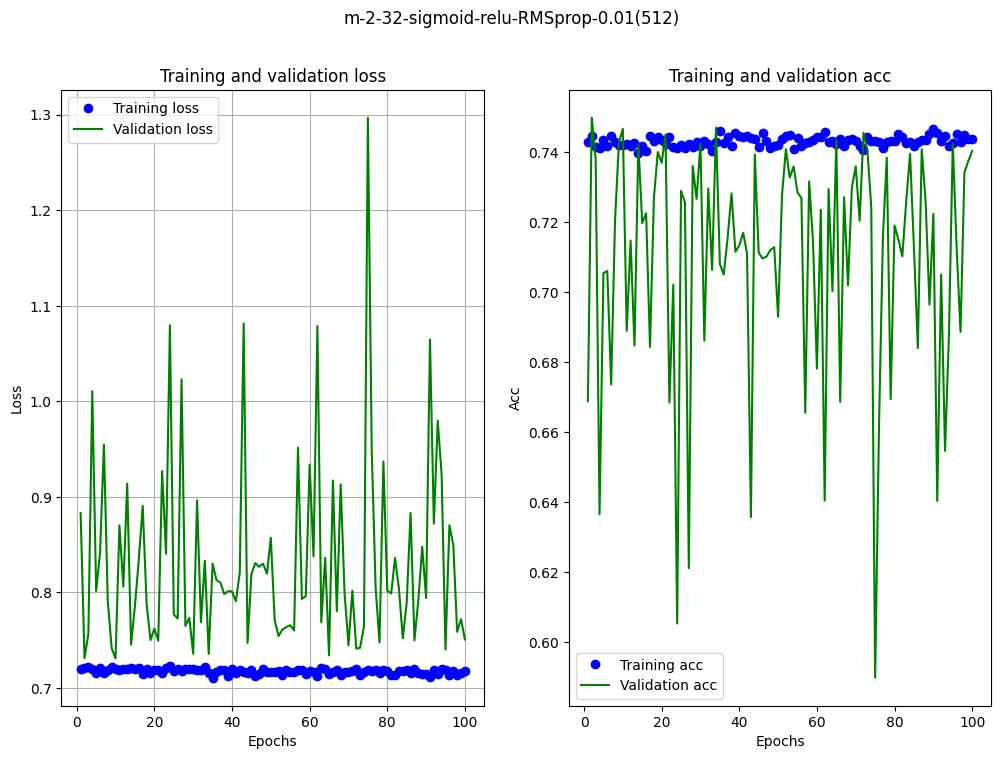

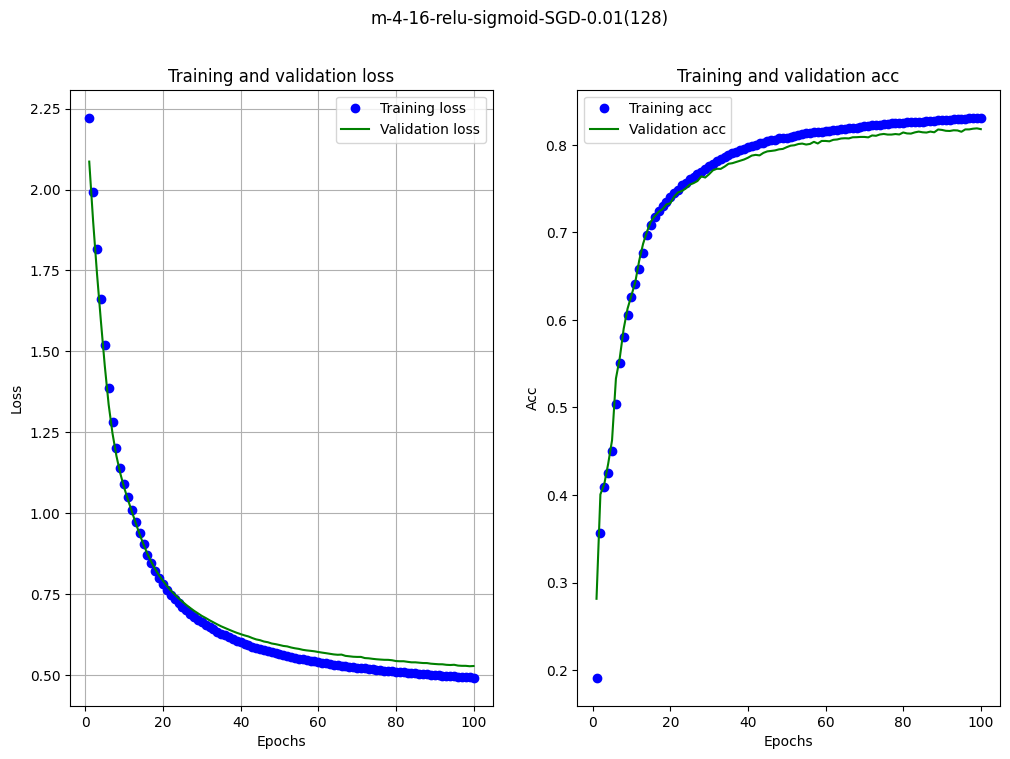

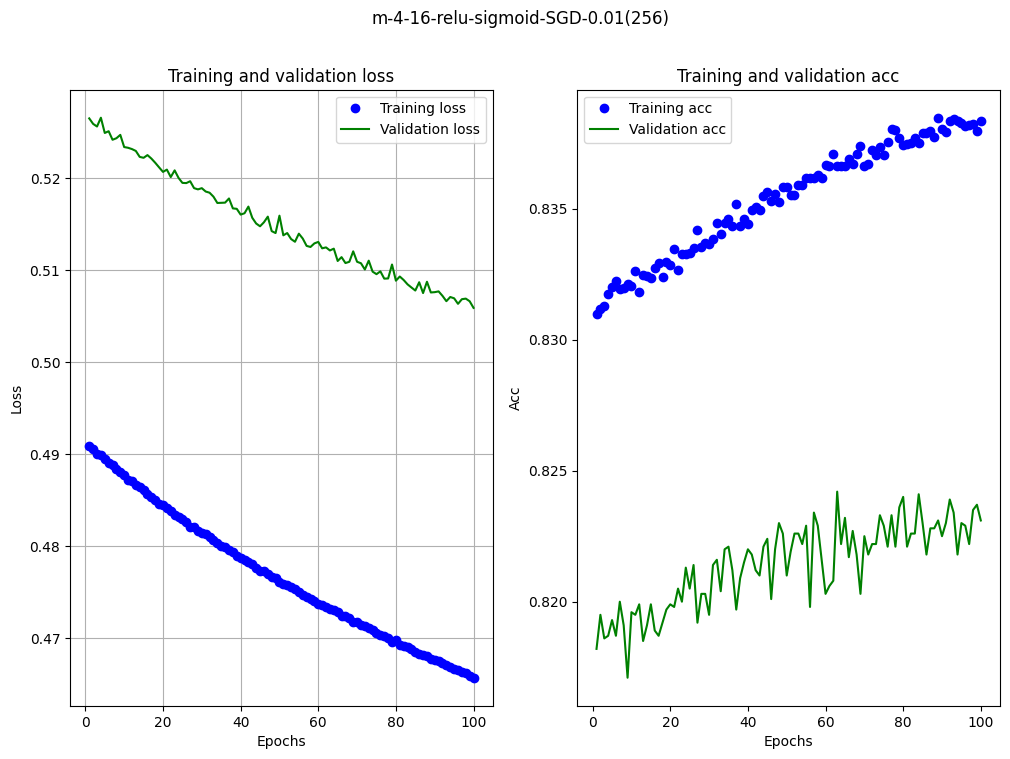

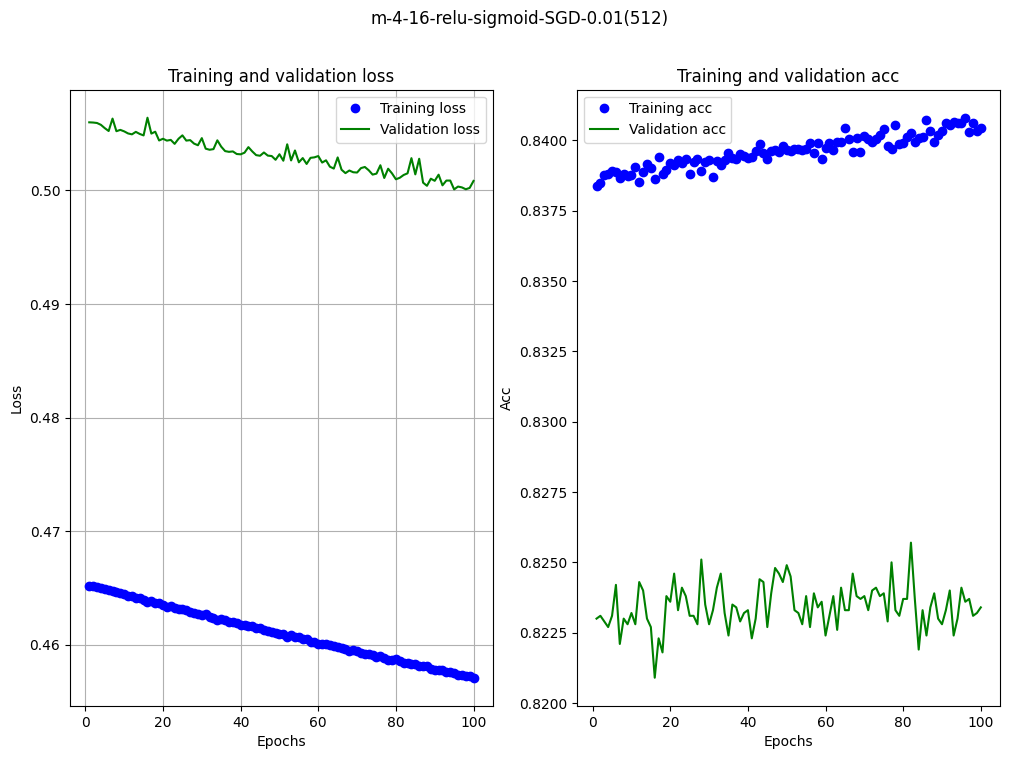

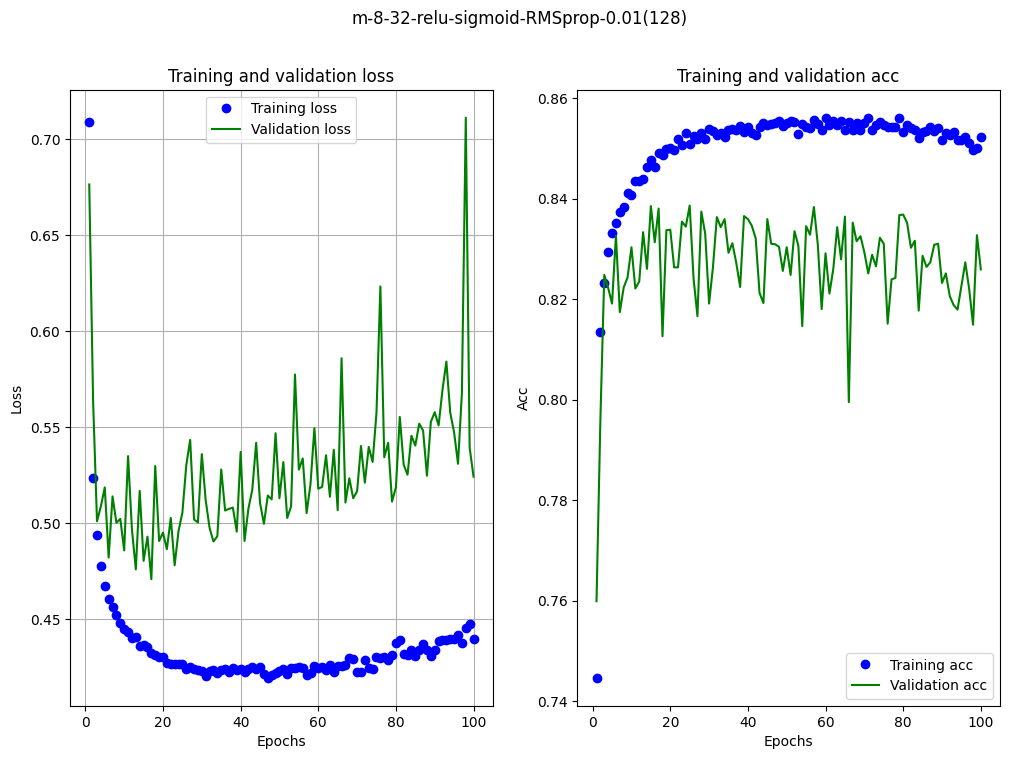

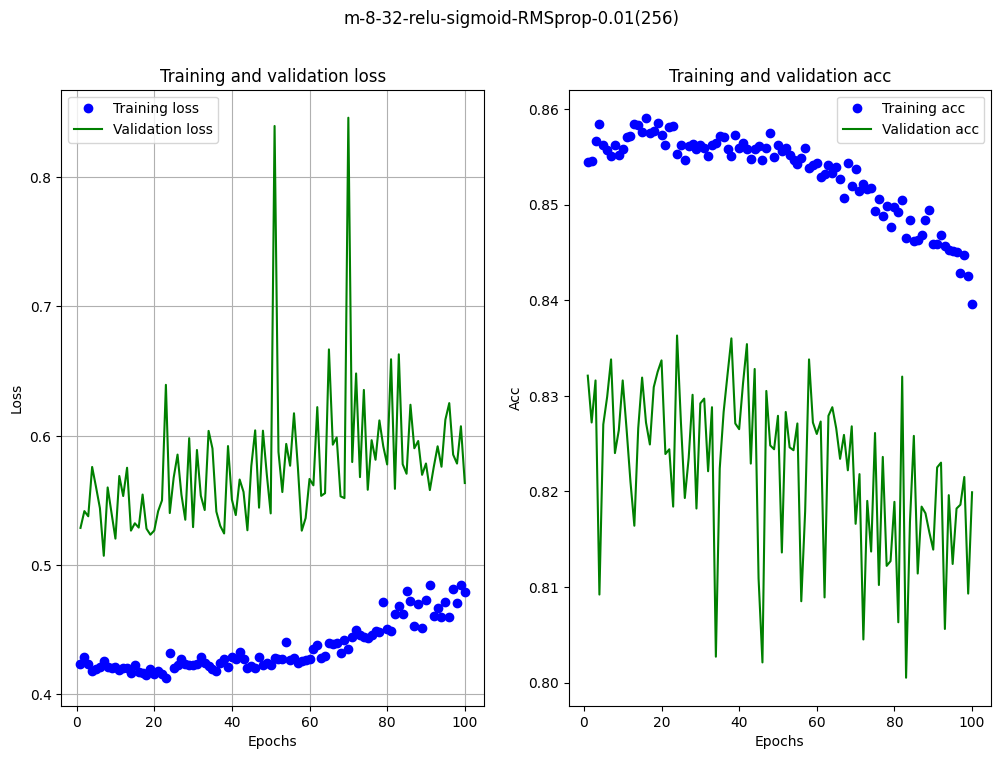

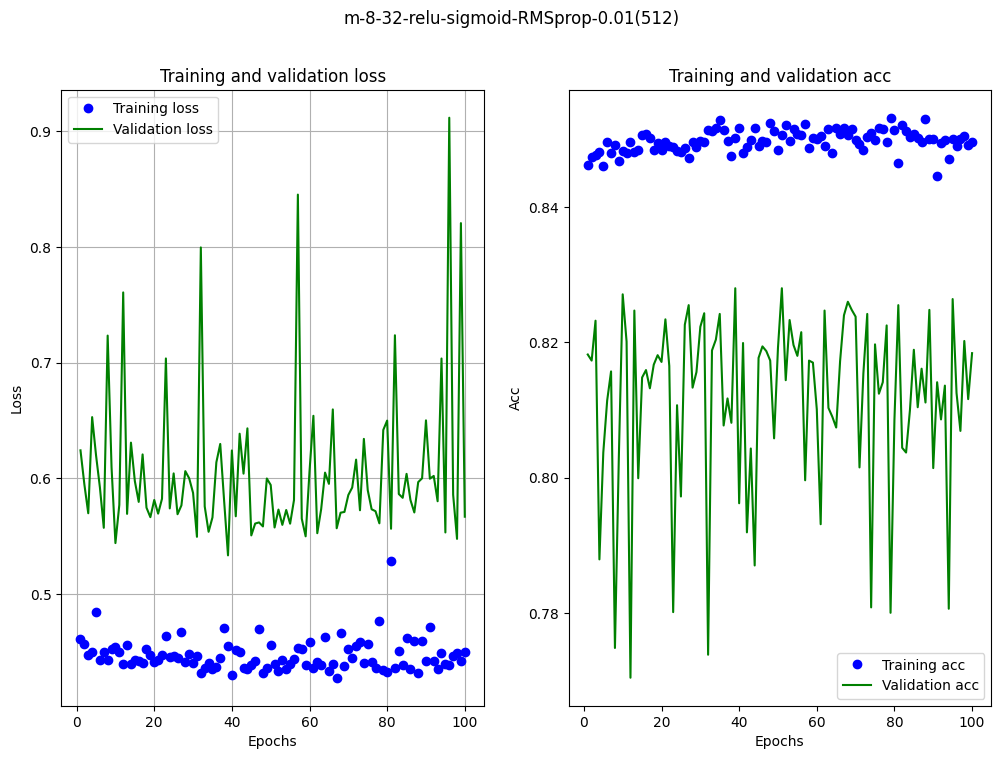

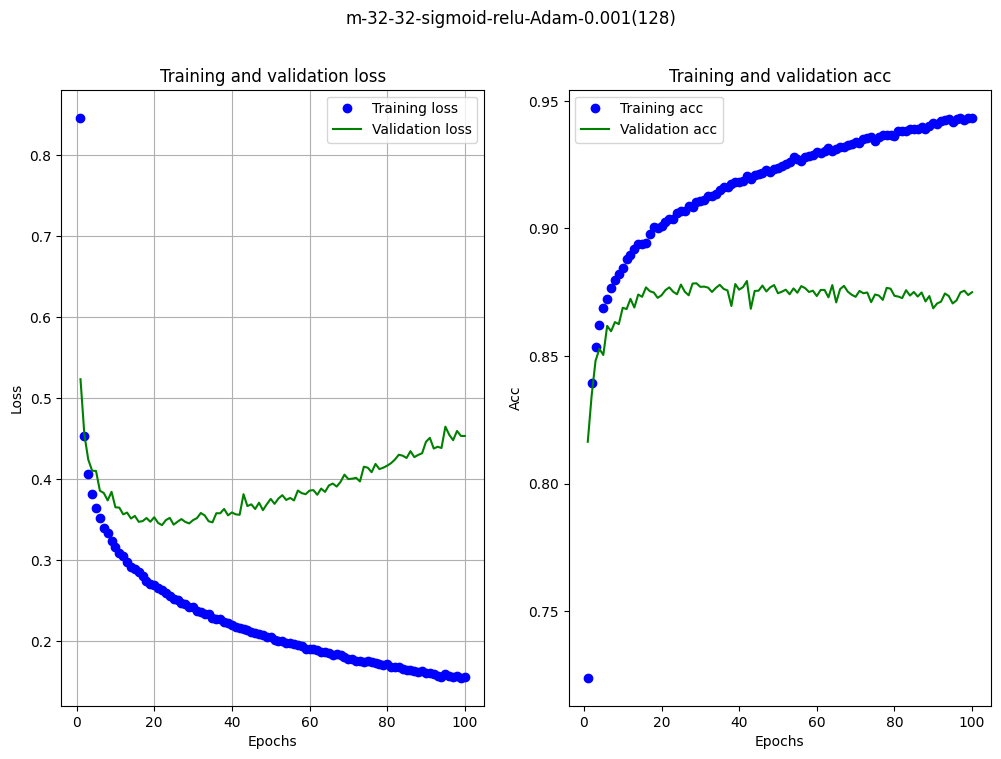

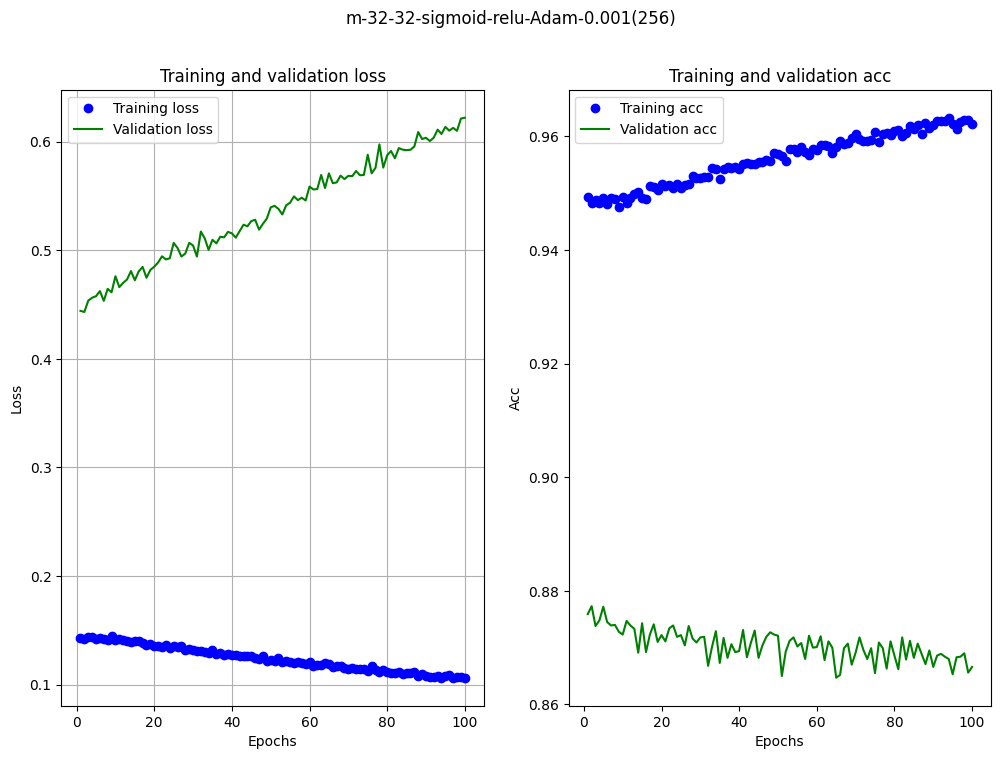

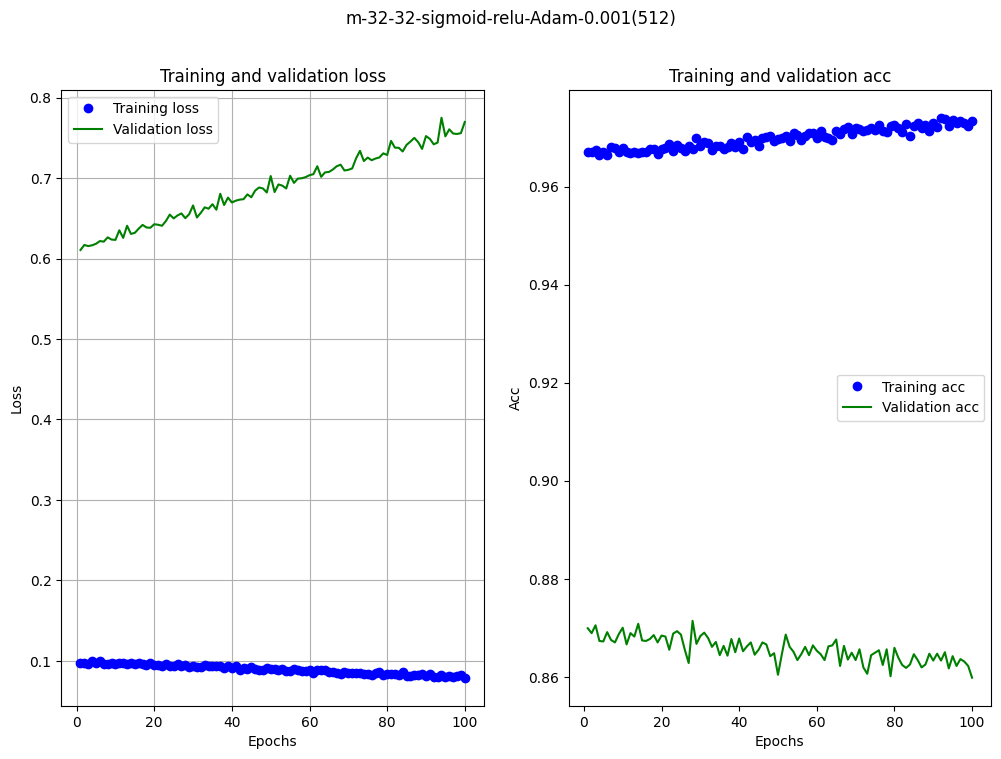

In [23]:
for model in history:
    history_dict = history[model].history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']   

    draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)


### __repeating__

In [24]:
def retest_NN(set_layers: list, act: list, opt: optimizers, lr: float, bs: int, epochs: int=100) -> None:
    """For retest one model."""
    models = [create_NN(
                        n_hidden_=set_layers, 
                        activation=act, 
                        optimizer=opt, 
                        learning_rate=lr
                        )] 

    history = {}
    history[f'{models[0].name}({bs})'] = models[0].fit(
                                                       x_train,
                                                       y_true,
                                                       epochs=epochs,
                                                       batch_size=bs,
                                                       validation_data=(x_test, y_truev)
                                                       )

    for model in history:
        history_dict = history[model].history

        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        acc_values = history_dict['categorical_accuracy']
        val_acc_values = history_dict['val_categorical_accuracy']   

        draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)

### __run__

Epoch 1/100
235/235 [==============================] - 1s 2ms/step - loss: 2.3031 - accuracy: 0.0568 - categorical_accuracy: 0.0568 - val_loss: 2.2843 - val_accuracy: 0.0832 - val_categorical_accuracy: 0.0832
Epoch 2/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2765 - accuracy: 0.1057 - categorical_accuracy: 0.1057 - val_loss: 2.2714 - val_accuracy: 0.1210 - val_categorical_accuracy: 0.1210
Epoch 3/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2648 - accuracy: 0.1347 - categorical_accuracy: 0.1347 - val_loss: 2.2602 - val_accuracy: 0.1443 - val_categorical_accuracy: 0.1443
Epoch 4/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2540 - accuracy: 0.1337 - categorical_accuracy: 0.1337 - val_loss: 2.2496 - val_accuracy: 0.1002 - val_categorical_accuracy: 0.1002
Epoch 5/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2436 - accuracy: 0.1090 - categorical_accuracy: 0.1090 - val_loss: 2.2393 - val_accurac

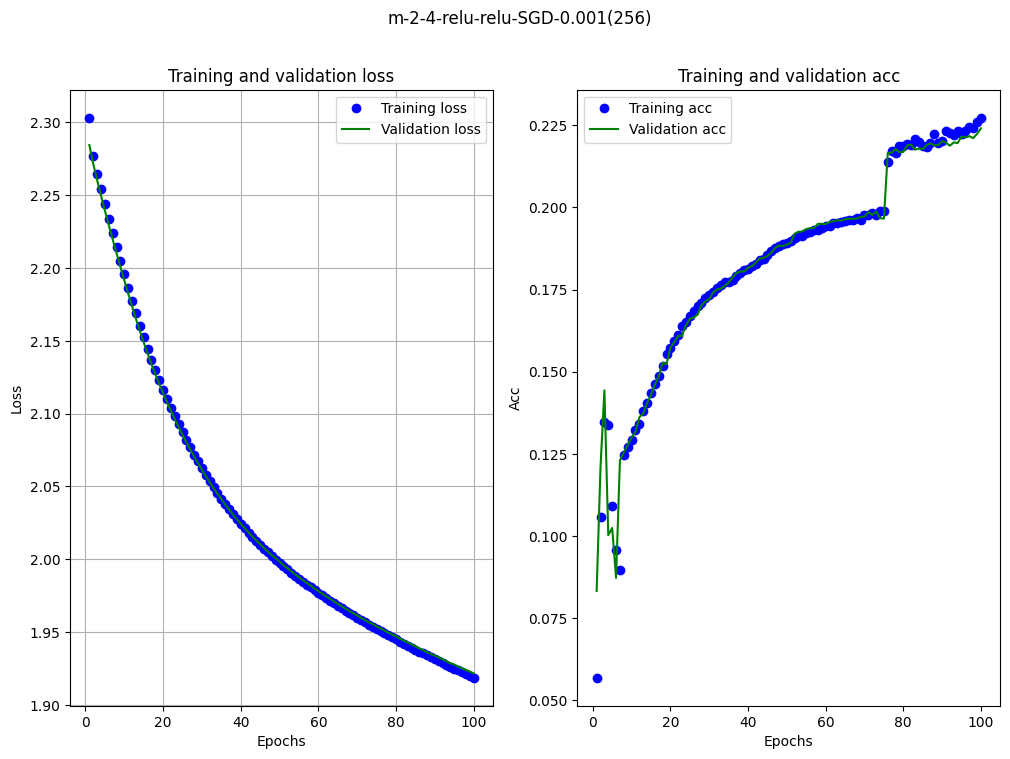

In [25]:
retest_NN(
          set_layers=[NUM_FEATURES, 2, 4, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=256,
          )

Epoch 1/100
235/235 [==============================] - 1s 2ms/step - loss: 2.3481 - accuracy: 0.1000 - categorical_accuracy: 0.1000 - val_loss: 2.3444 - val_accuracy: 0.1000 - val_categorical_accuracy: 0.1000
Epoch 2/100
235/235 [==============================] - 0s 2ms/step - loss: 2.3412 - accuracy: 0.1000 - categorical_accuracy: 0.1000 - val_loss: 2.3383 - val_accuracy: 0.1000 - val_categorical_accuracy: 0.1000
Epoch 3/100
235/235 [==============================] - 0s 2ms/step - loss: 2.3357 - accuracy: 0.1000 - categorical_accuracy: 0.1000 - val_loss: 2.3333 - val_accuracy: 0.1000 - val_categorical_accuracy: 0.1000
Epoch 4/100
235/235 [==============================] - 0s 2ms/step - loss: 2.3311 - accuracy: 0.1000 - categorical_accuracy: 0.1000 - val_loss: 2.3292 - val_accuracy: 0.1000 - val_categorical_accuracy: 0.1000
Epoch 5/100
235/235 [==============================] - 0s 2ms/step - loss: 2.3274 - accuracy: 0.1000 - categorical_accuracy: 0.1000 - val_loss: 2.3258 - val_accurac

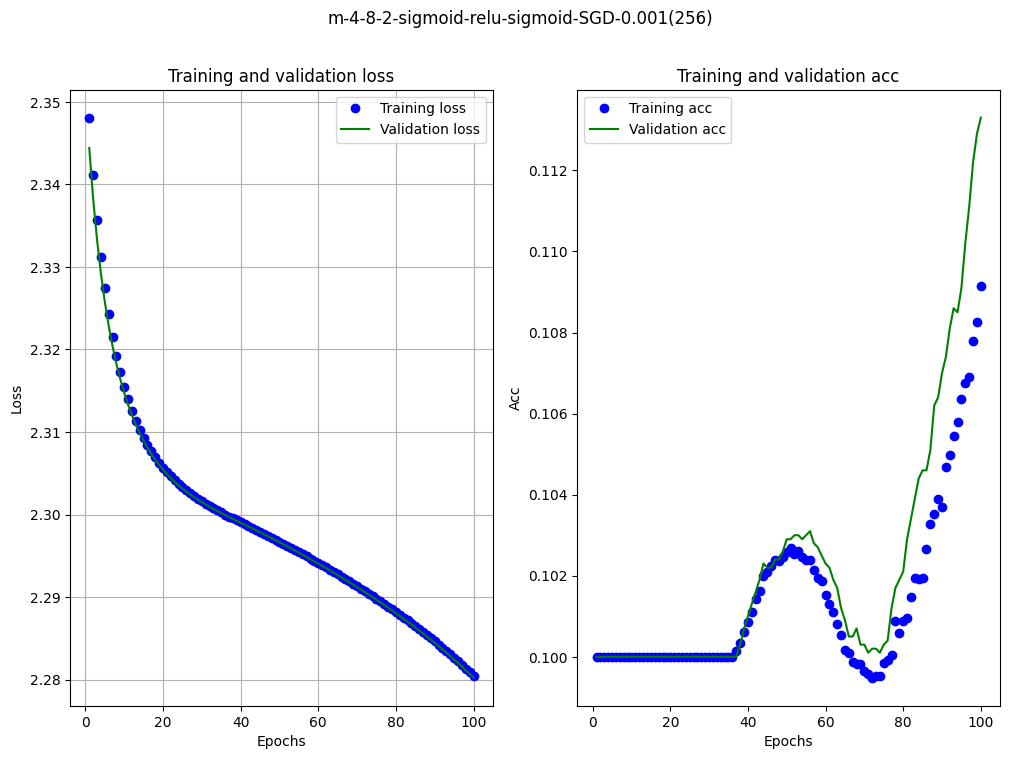

In [26]:
retest_NN(
          set_layers=[NUM_FEATURES, 4, 8, 2, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=256,
          )

Epoch 1/100
235/235 [==============================] - 1s 2ms/step - loss: 2.3050 - accuracy: 0.0848 - categorical_accuracy: 0.0848 - val_loss: 2.3009 - val_accuracy: 0.0720 - val_categorical_accuracy: 0.0720
Epoch 2/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2981 - accuracy: 0.0695 - categorical_accuracy: 0.0695 - val_loss: 2.2961 - val_accuracy: 0.0714 - val_categorical_accuracy: 0.0714
Epoch 3/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2940 - accuracy: 0.0779 - categorical_accuracy: 0.0779 - val_loss: 2.2925 - val_accuracy: 0.0877 - val_categorical_accuracy: 0.0877
Epoch 4/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2904 - accuracy: 0.0965 - categorical_accuracy: 0.0965 - val_loss: 2.2890 - val_accuracy: 0.1107 - val_categorical_accuracy: 0.1107
Epoch 5/100
235/235 [==============================] - 0s 2ms/step - loss: 2.2868 - accuracy: 0.1180 - categorical_accuracy: 0.1180 - val_loss: 2.2854 - val_accurac

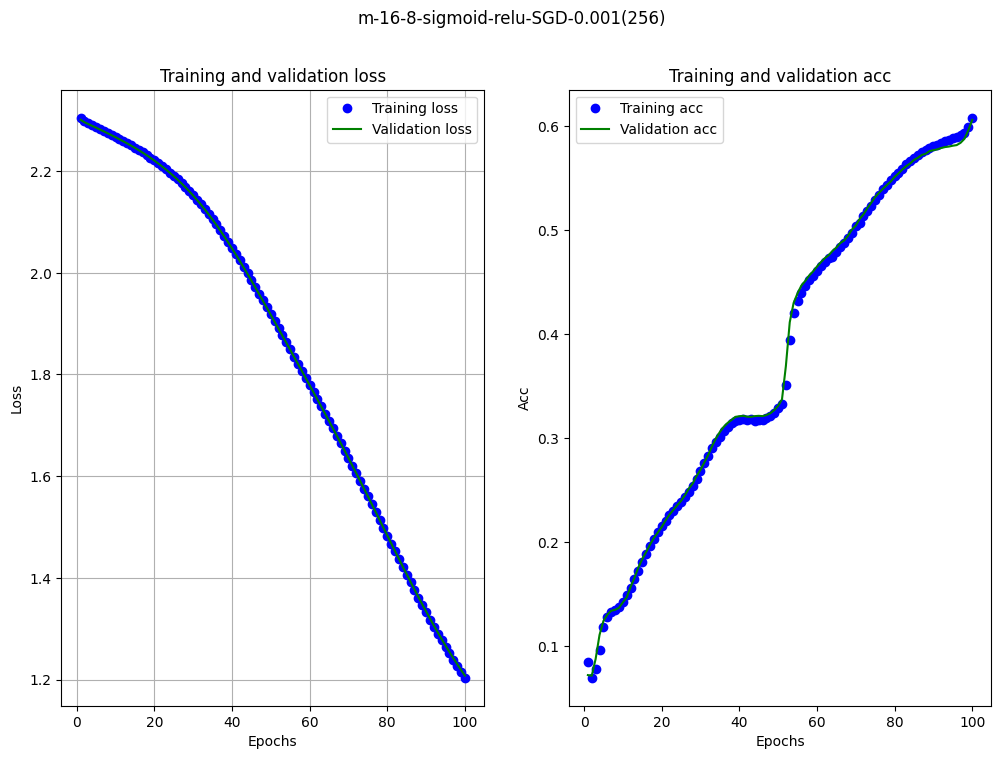

In [27]:
retest_NN(
          set_layers=[NUM_FEATURES, 16, 8, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=256,
          )

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 2.3140 - accuracy: 0.1155 - categorical_accuracy: 0.1155 - val_loss: 2.2842 - val_accuracy: 0.1396 - val_categorical_accuracy: 0.1396
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 2.2602 - accuracy: 0.1964 - categorical_accuracy: 0.1964 - val_loss: 2.2388 - val_accuracy: 0.2581 - val_categorical_accuracy: 0.2581
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 2.2190 - accuracy: 0.2955 - categorical_accuracy: 0.2955 - val_loss: 2.2012 - val_accuracy: 0.3274 - val_categorical_accuracy: 0.3274
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 2.1830 - accuracy: 0.3355 - categorical_accuracy: 0.3355 - val_loss: 2.1665 - val_accuracy: 0.3468 - val_categorical_accuracy: 0.3468
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 2.1481 - accuracy: 0.3506 - categorical_accuracy: 0.3506 - val_loss: 2.1317 - val_accurac

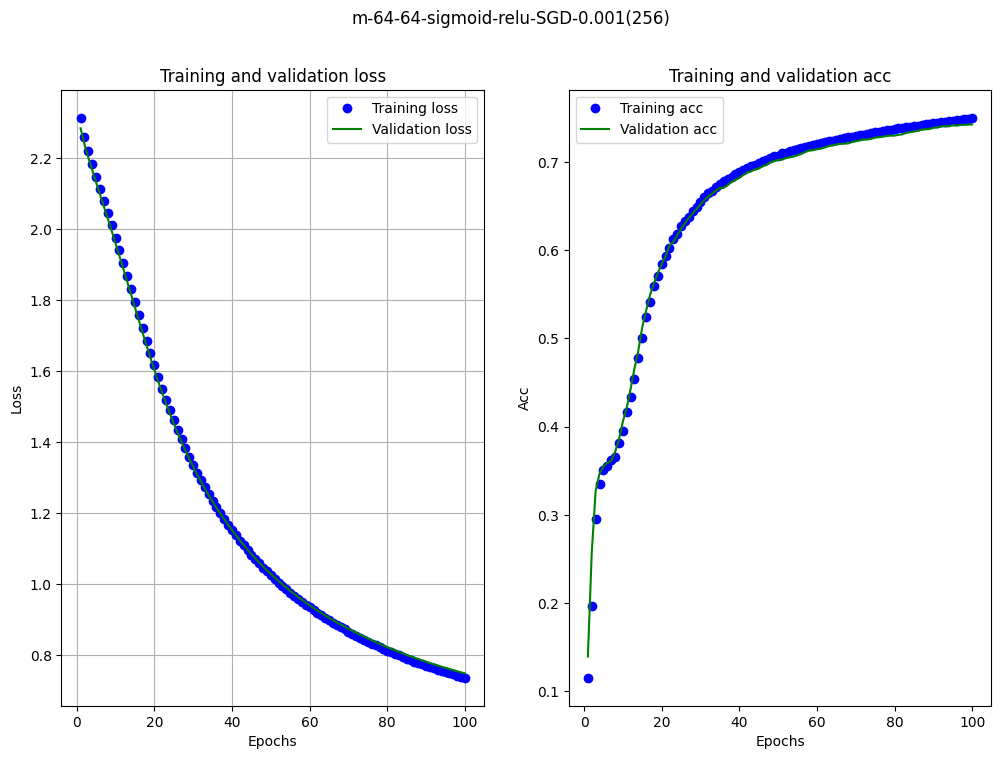

In [28]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=256,
          )

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 2.2853 - accuracy: 0.1330 - categorical_accuracy: 0.1330 - val_loss: 2.2367 - val_accuracy: 0.1788 - val_categorical_accuracy: 0.1788
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 2.2070 - accuracy: 0.2804 - categorical_accuracy: 0.2804 - val_loss: 2.1817 - val_accuracy: 0.3860 - val_categorical_accuracy: 0.3860
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 2.1577 - accuracy: 0.4491 - categorical_accuracy: 0.4491 - val_loss: 2.1357 - val_accuracy: 0.4825 - val_categorical_accuracy: 0.4825
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 2.1119 - accuracy: 0.4990 - categorical_accuracy: 0.4990 - val_loss: 2.0902 - val_accuracy: 0.5085 - val_categorical_accuracy: 0.5085
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 2.0659 - accuracy: 0.5201 - categorical_accuracy: 0.5201 - val_loss: 2.0439 - val_accurac

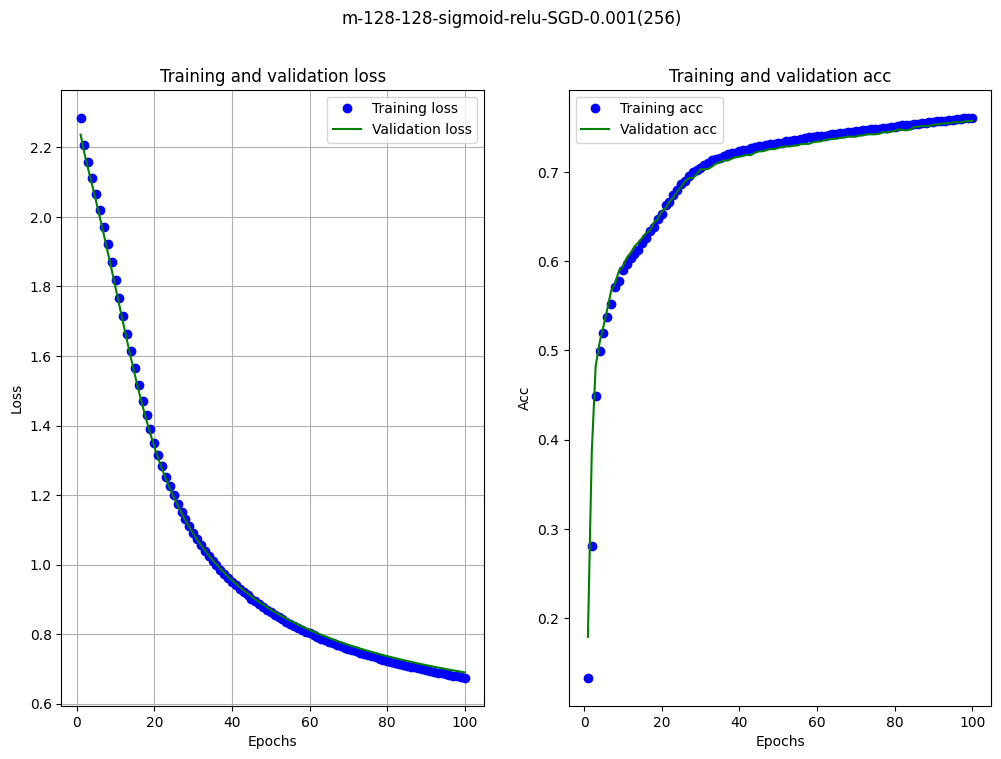

In [29]:
retest_NN(
          set_layers=[NUM_FEATURES, 128, 128, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=256,
          )

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 0.8429 - accuracy: 0.7421 - categorical_accuracy: 0.7421 - val_loss: 0.5329 - val_accuracy: 0.8108 - val_categorical_accuracy: 0.8108
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.4644 - accuracy: 0.8361 - categorical_accuracy: 0.8361 - val_loss: 0.4587 - val_accuracy: 0.8349 - val_categorical_accuracy: 0.8349
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 0.4117 - accuracy: 0.8522 - categorical_accuracy: 0.8522 - val_loss: 0.4263 - val_accuracy: 0.8480 - val_categorical_accuracy: 0.8480
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3861 - accuracy: 0.8606 - categorical_accuracy: 0.8606 - val_loss: 0.4100 - val_accuracy: 0.8510 - val_categorical_accuracy: 0.8510
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3677 - accuracy: 0.8683 - categorical_accuracy: 0.8683 - val_loss: 0.4008 - val_accurac

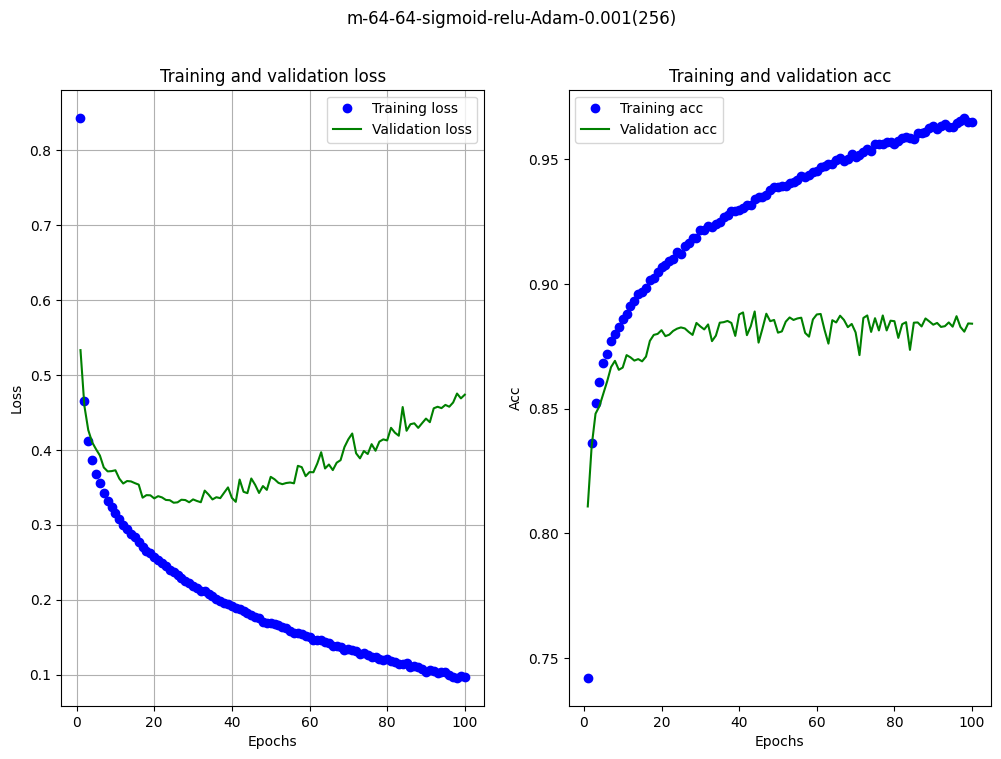

In [30]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=256,
          )

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 0.8142 - accuracy: 0.7461 - categorical_accuracy: 0.7461 - val_loss: 0.5488 - val_accuracy: 0.8039 - val_categorical_accuracy: 0.8039
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.4684 - accuracy: 0.8329 - categorical_accuracy: 0.8329 - val_loss: 0.4812 - val_accuracy: 0.8272 - val_categorical_accuracy: 0.8272
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 0.4218 - accuracy: 0.8478 - categorical_accuracy: 0.8478 - val_loss: 0.4714 - val_accuracy: 0.8276 - val_categorical_accuracy: 0.8276
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3960 - accuracy: 0.8576 - categorical_accuracy: 0.8576 - val_loss: 0.4200 - val_accuracy: 0.8486 - val_categorical_accuracy: 0.8486
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3790 - accuracy: 0.8627 - categorical_accuracy: 0.8627 - val_loss: 0.4009 - val_accurac

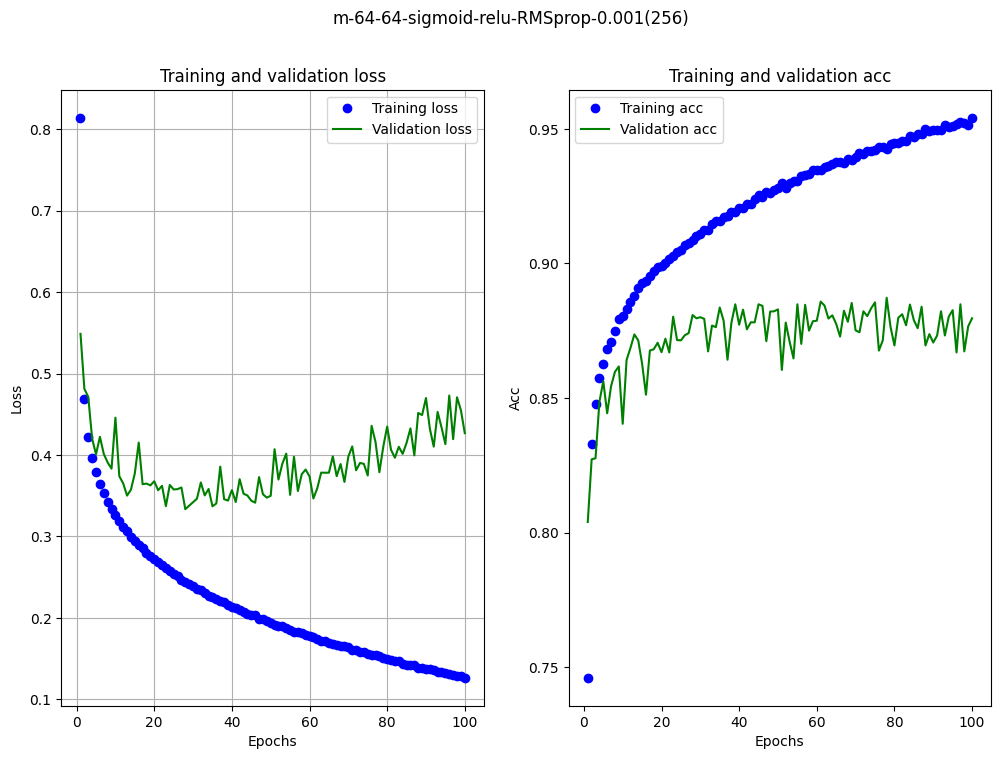

In [31]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.RMSprop, 
          lr=0.001,
          bs=256,
          )

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 0.5521 - accuracy: 0.7993 - categorical_accuracy: 0.7993 - val_loss: 0.4527 - val_accuracy: 0.8363 - val_categorical_accuracy: 0.8363
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3863 - accuracy: 0.8596 - categorical_accuracy: 0.8596 - val_loss: 0.4483 - val_accuracy: 0.8331 - val_categorical_accuracy: 0.8331
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3526 - accuracy: 0.8704 - categorical_accuracy: 0.8704 - val_loss: 0.4028 - val_accuracy: 0.8525 - val_categorical_accuracy: 0.8525
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3304 - accuracy: 0.8778 - categorical_accuracy: 0.8778 - val_loss: 0.3803 - val_accuracy: 0.8606 - val_categorical_accuracy: 0.8606
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.3193 - accuracy: 0.8824 - categorical_accuracy: 0.8824 - val_loss: 0.3673 - val_accurac

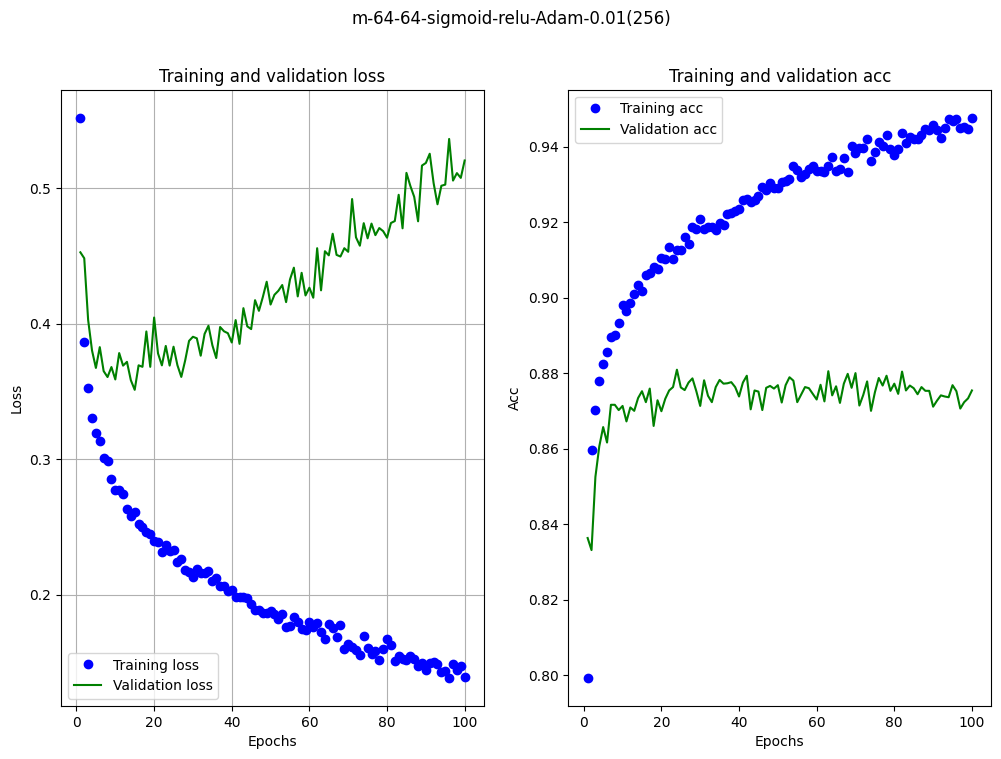

In [32]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.01,
          bs=256,
          )

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 1.8584 - accuracy: 0.4807 - categorical_accuracy: 0.4807 - val_loss: 1.4688 - val_accuracy: 0.6571 - val_categorical_accuracy: 0.6571
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 1.2175 - accuracy: 0.6916 - categorical_accuracy: 0.6916 - val_loss: 1.0348 - val_accuracy: 0.7054 - val_categorical_accuracy: 0.7054
Epoch 3/100
235/235 [==============================] - 1s 3ms/step - loss: 0.9033 - accuracy: 0.7327 - categorical_accuracy: 0.7327 - val_loss: 0.8230 - val_accuracy: 0.7385 - val_categorical_accuracy: 0.7385
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.7489 - accuracy: 0.7602 - categorical_accuracy: 0.7602 - val_loss: 0.7166 - val_accuracy: 0.7626 - val_categorical_accuracy: 0.7626
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.6644 - accuracy: 0.7796 - categorical_accuracy: 0.7796 - val_loss: 0.6543 - val_accurac

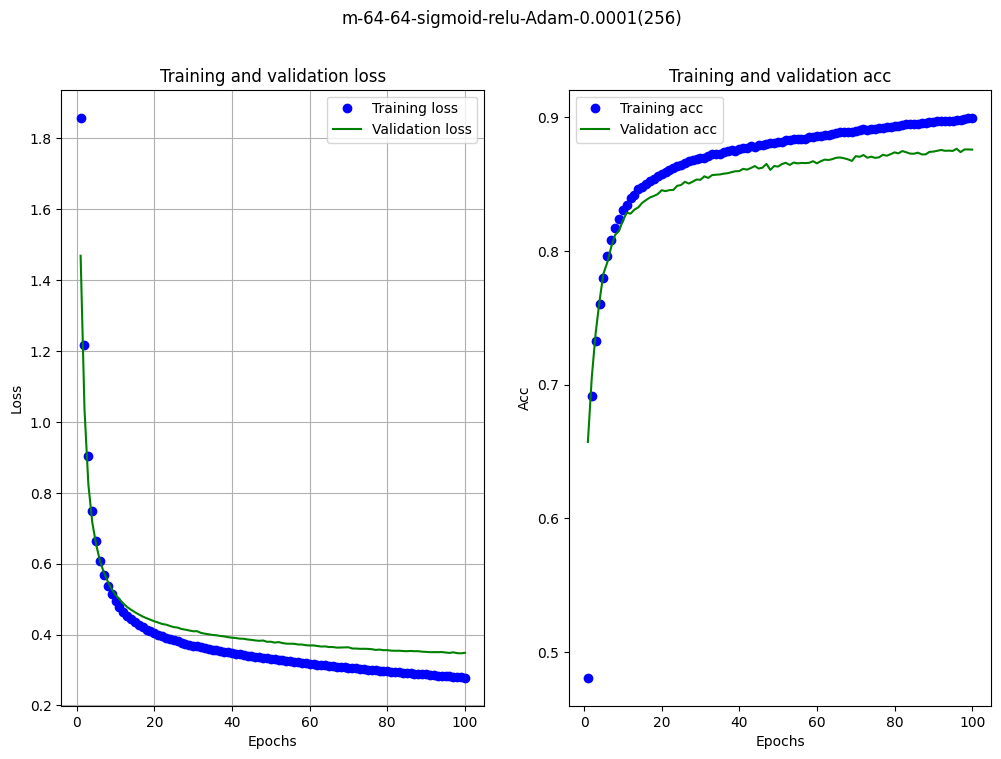

In [33]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.0001,
          bs=256,
          )

Epoch 1/100
469/469 [==============================] - 1s 2ms/step - loss: 0.7046 - accuracy: 0.7747 - categorical_accuracy: 0.7747 - val_loss: 0.4822 - val_accuracy: 0.8272 - val_categorical_accuracy: 0.8272
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 0.4243 - accuracy: 0.8469 - categorical_accuracy: 0.8469 - val_loss: 0.4232 - val_accuracy: 0.8477 - val_categorical_accuracy: 0.8477
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3858 - accuracy: 0.8607 - categorical_accuracy: 0.8607 - val_loss: 0.4247 - val_accuracy: 0.8471 - val_categorical_accuracy: 0.8471
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3601 - accuracy: 0.8698 - categorical_accuracy: 0.8698 - val_loss: 0.3904 - val_accuracy: 0.8597 - val_categorical_accuracy: 0.8597
Epoch 5/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3421 - accuracy: 0.8745 - categorical_accuracy: 0.8745 - val_loss: 0.3983 - val_accurac

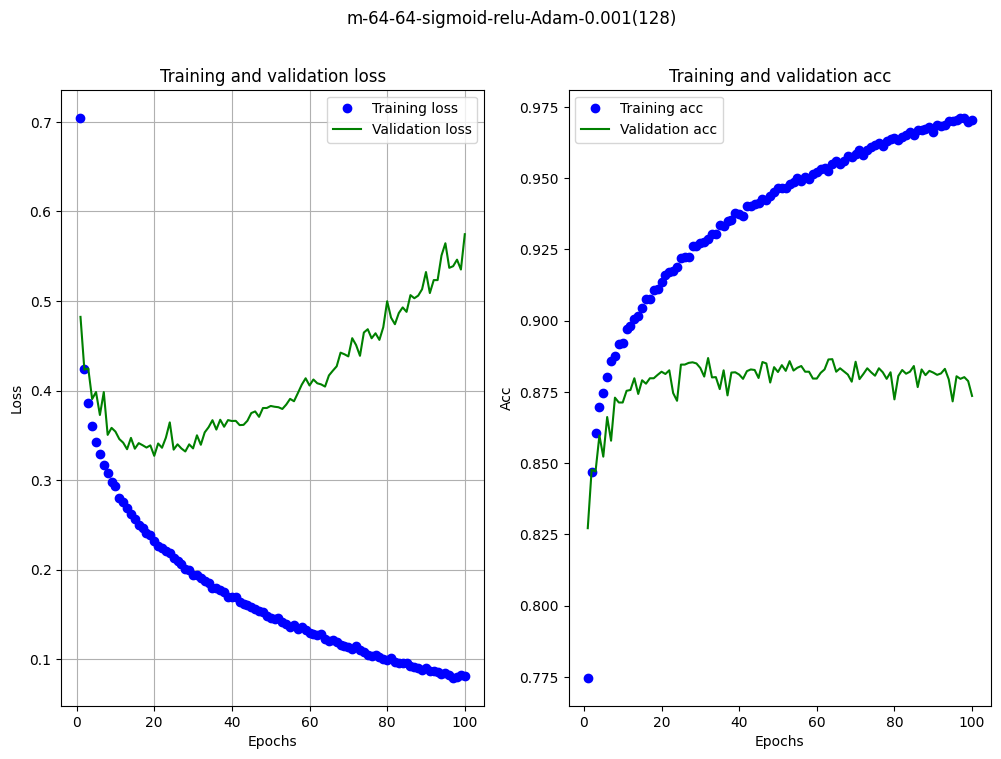

In [34]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=128,
          )

Epoch 1/100
118/118 [==============================] - 1s 4ms/step - loss: 1.1068 - accuracy: 0.6718 - categorical_accuracy: 0.6718 - val_loss: 0.6467 - val_accuracy: 0.7763 - val_categorical_accuracy: 0.7763
Epoch 2/100
118/118 [==============================] - 0s 3ms/step - loss: 0.5409 - accuracy: 0.8152 - categorical_accuracy: 0.8152 - val_loss: 0.5120 - val_accuracy: 0.8156 - val_categorical_accuracy: 0.8156
Epoch 3/100
118/118 [==============================] - 0s 3ms/step - loss: 0.4547 - accuracy: 0.8380 - categorical_accuracy: 0.8380 - val_loss: 0.4645 - val_accuracy: 0.8313 - val_categorical_accuracy: 0.8313
Epoch 4/100
118/118 [==============================] - 0s 3ms/step - loss: 0.4185 - accuracy: 0.8509 - categorical_accuracy: 0.8509 - val_loss: 0.4391 - val_accuracy: 0.8423 - val_categorical_accuracy: 0.8423
Epoch 5/100
118/118 [==============================] - 0s 3ms/step - loss: 0.3961 - accuracy: 0.8587 - categorical_accuracy: 0.8587 - val_loss: 0.4228 - val_accurac

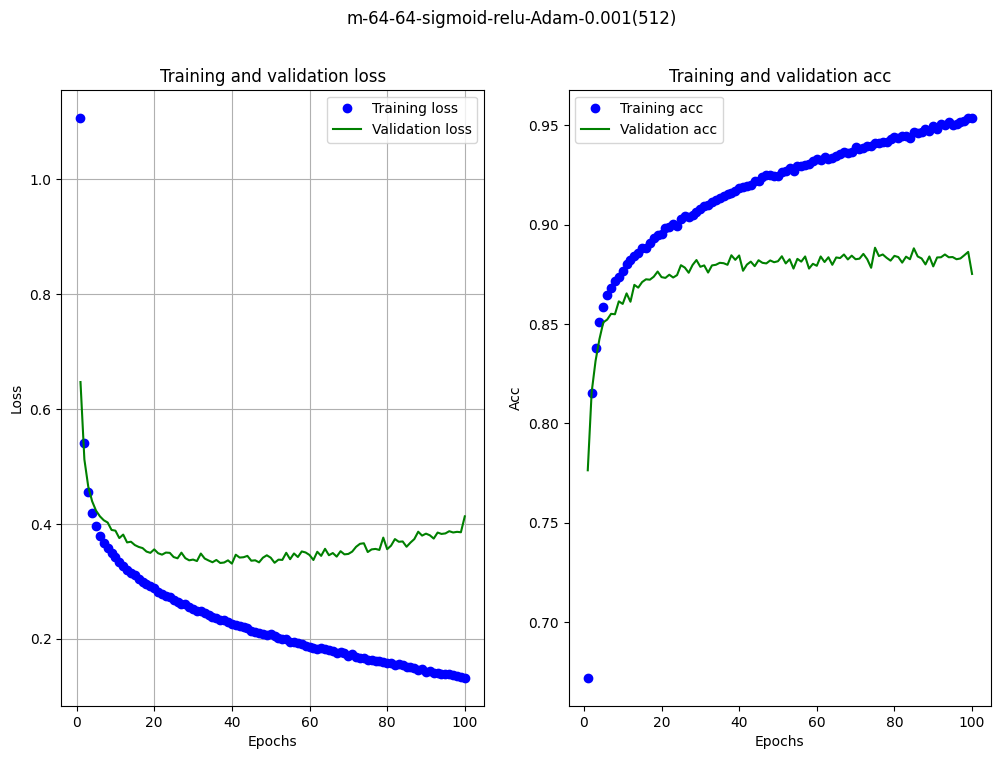

In [35]:
retest_NN(
          set_layers=[NUM_FEATURES, 64, 64, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=512,
          )

Epoch 1/100
118/118 [==============================] - 1s 6ms/step - loss: 0.8996 - accuracy: 0.7282 - categorical_accuracy: 0.7282 - val_loss: 0.5534 - val_accuracy: 0.8069 - val_categorical_accuracy: 0.8069
Epoch 2/100
118/118 [==============================] - 1s 5ms/step - loss: 0.4833 - accuracy: 0.8304 - categorical_accuracy: 0.8304 - val_loss: 0.4769 - val_accuracy: 0.8265 - val_categorical_accuracy: 0.8265
Epoch 3/100
118/118 [==============================] - 1s 5ms/step - loss: 0.4317 - accuracy: 0.8465 - categorical_accuracy: 0.8465 - val_loss: 0.4430 - val_accuracy: 0.8406 - val_categorical_accuracy: 0.8406
Epoch 4/100
118/118 [==============================] - 1s 5ms/step - loss: 0.4003 - accuracy: 0.8571 - categorical_accuracy: 0.8571 - val_loss: 0.4265 - val_accuracy: 0.8483 - val_categorical_accuracy: 0.8483
Epoch 5/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3820 - accuracy: 0.8636 - categorical_accuracy: 0.8636 - val_loss: 0.4171 - val_accurac

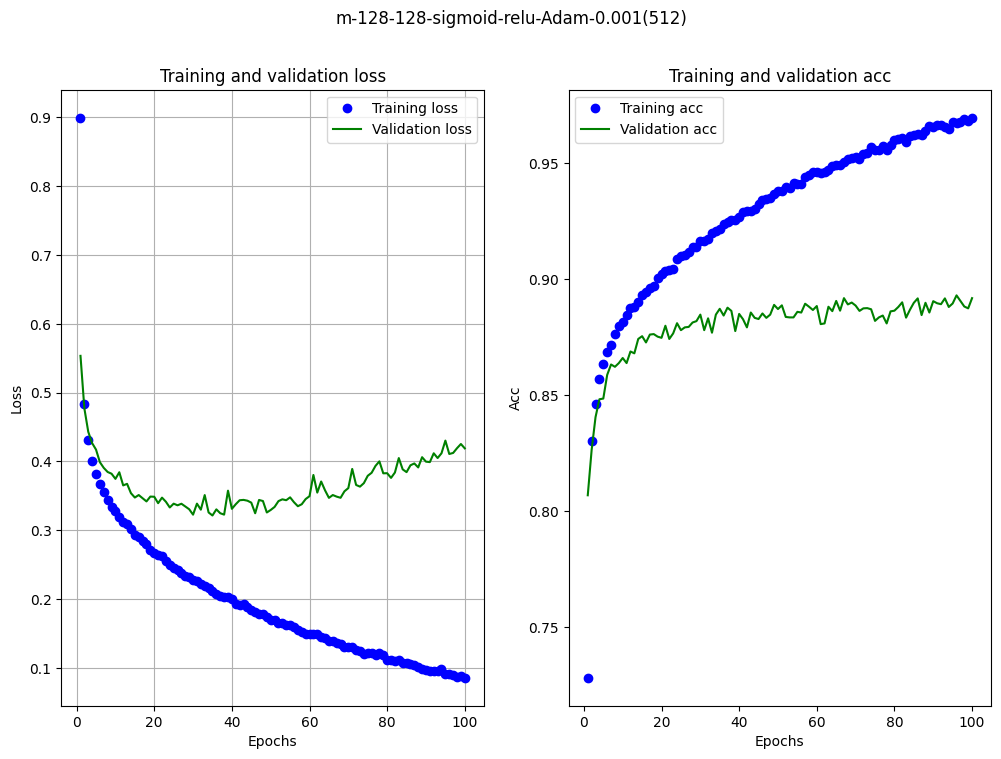

In [36]:
retest_NN(
          set_layers=[NUM_FEATURES, 128, 128, NUM_CLASSES], 
          act=['sigmoid', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=512,
          )

Epoch 1/100
118/118 [==============================] - 1s 6ms/step - loss: 0.6660 - accuracy: 0.7736 - categorical_accuracy: 0.7736 - val_loss: 0.5207 - val_accuracy: 0.8136 - val_categorical_accuracy: 0.8136
Epoch 2/100
118/118 [==============================] - 1s 5ms/step - loss: 0.4364 - accuracy: 0.8448 - categorical_accuracy: 0.8448 - val_loss: 0.4419 - val_accuracy: 0.8388 - val_categorical_accuracy: 0.8388
Epoch 3/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3933 - accuracy: 0.8602 - categorical_accuracy: 0.8602 - val_loss: 0.4115 - val_accuracy: 0.8545 - val_categorical_accuracy: 0.8545
Epoch 4/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3620 - accuracy: 0.8705 - categorical_accuracy: 0.8705 - val_loss: 0.3977 - val_accuracy: 0.8571 - val_categorical_accuracy: 0.8571
Epoch 5/100
118/118 [==============================] - 1s 5ms/step - loss: 0.3473 - accuracy: 0.8745 - categorical_accuracy: 0.8745 - val_loss: 0.4052 - val_accurac

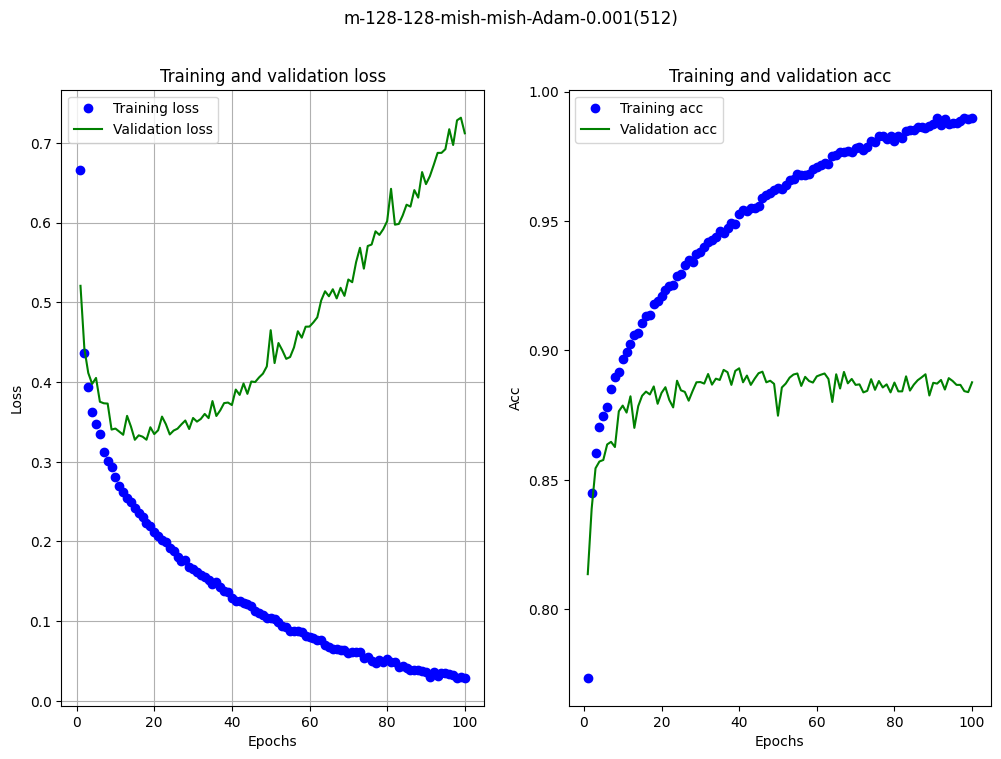

In [37]:
retest_NN(
          set_layers=[NUM_FEATURES, 128, 128, NUM_CLASSES], 
          act=['mish', 'mish', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=512,
          )

Варіант 1:

Epoch 1/100
469/469 [==============================] - 3s 6ms/step - loss: 0.5113 - accuracy: 0.8187 - categorical_accuracy: 0.8187 - val_loss: 0.4193 - val_accuracy: 0.8516 - val_categorical_accuracy: 0.8516
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: 0.3604 - accuracy: 0.8688 - categorical_accuracy: 0.8688 - val_loss: 0.3741 - val_accuracy: 0.8650 - val_categorical_accuracy: 0.8650
Epoch 3/100
469/469 [==============================] - 3s 5ms/step - loss: 0.3281 - accuracy: 0.8778 - categorical_accuracy: 0.8778 - val_loss: 0.3463 - val_accuracy: 0.8738 - val_categorical_accuracy: 0.8738
Epoch 4/100
469/469 [==============================] - 3s 5ms/step - loss: 0.2969 - accuracy: 0.8900 - categorical_accuracy: 0.8900 - val_loss: 0.3420 - val_accuracy: 0.8746 - val_categorical_accuracy: 0.8746
Epoch 5/100
469/469 [==============================] - 3s 5ms/step - loss: 0.2804 - accuracy: 0.8954 - categorical_accuracy: 0.8954 - val_loss: 0.3587 - val_accurac

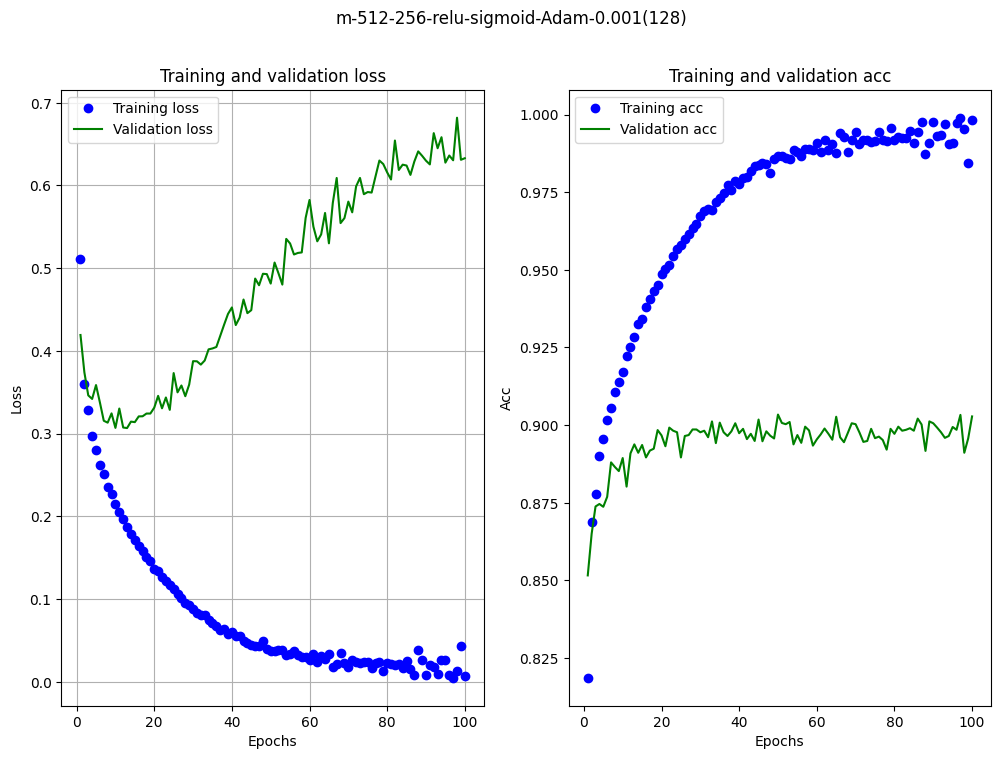

In [38]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 256, NUM_CLASSES], 
          act=['relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=128,
          )

Epoch 1/100
30/30 [==============================] - 1s 27ms/step - loss: 9.1928 - accuracy: 0.1259 - categorical_accuracy: 0.1259 - val_loss: 2.9015 - val_accuracy: 0.1718 - val_categorical_accuracy: 0.1718
Epoch 2/100
30/30 [==============================] - 1s 24ms/step - loss: 2.3193 - accuracy: 0.2005 - categorical_accuracy: 0.2005 - val_loss: 1.8844 - val_accuracy: 0.2782 - val_categorical_accuracy: 0.2782
Epoch 3/100
30/30 [==============================] - 1s 24ms/step - loss: 1.9178 - accuracy: 0.2415 - categorical_accuracy: 0.2415 - val_loss: 1.7152 - val_accuracy: 0.2509 - val_categorical_accuracy: 0.2509
Epoch 4/100
30/30 [==============================] - 1s 25ms/step - loss: 1.6413 - accuracy: 0.3193 - categorical_accuracy: 0.3193 - val_loss: 1.6842 - val_accuracy: 0.1981 - val_categorical_accuracy: 0.1981
Epoch 5/100
30/30 [==============================] - 1s 24ms/step - loss: 1.6415 - accuracy: 0.3122 - categorical_accuracy: 0.3122 - val_loss: 1.5978 - val_accuracy: 0.

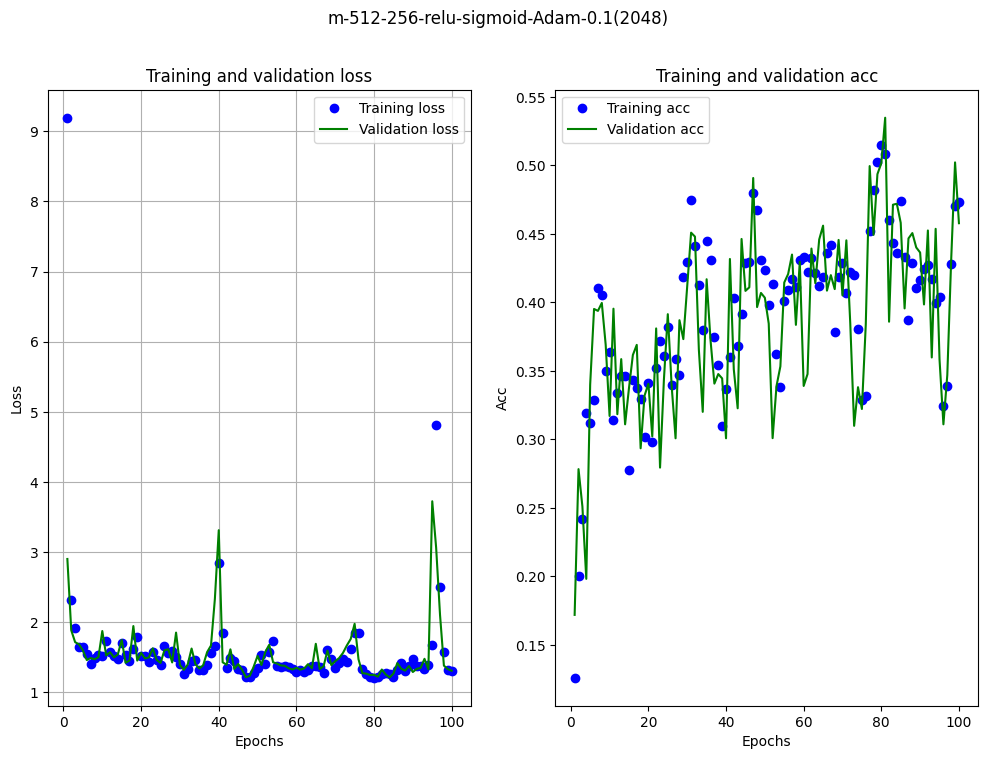

In [39]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 256, NUM_CLASSES], 
          act=['relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.1,
          bs=2048,
          )

Варіант 2:

Epoch 1/100
118/118 [==============================] - 2s 11ms/step - loss: 0.6203 - accuracy: 0.7928 - categorical_accuracy: 0.7928 - val_loss: 0.4853 - val_accuracy: 0.8310 - val_categorical_accuracy: 0.8310
Epoch 2/100
118/118 [==============================] - 1s 10ms/step - loss: 0.4324 - accuracy: 0.8505 - categorical_accuracy: 0.8505 - val_loss: 0.4637 - val_accuracy: 0.8362 - val_categorical_accuracy: 0.8362
Epoch 3/100
118/118 [==============================] - 1s 12ms/step - loss: 0.3894 - accuracy: 0.8636 - categorical_accuracy: 0.8636 - val_loss: 0.4060 - val_accuracy: 0.8554 - val_categorical_accuracy: 0.8554
Epoch 4/100
118/118 [==============================] - 1s 11ms/step - loss: 0.3640 - accuracy: 0.8723 - categorical_accuracy: 0.8723 - val_loss: 0.3971 - val_accuracy: 0.8594 - val_categorical_accuracy: 0.8594
Epoch 5/100
118/118 [==============================] - 1s 10ms/step - loss: 0.3490 - accuracy: 0.8768 - categorical_accuracy: 0.8768 - val_loss: 0.3719 - val_ac

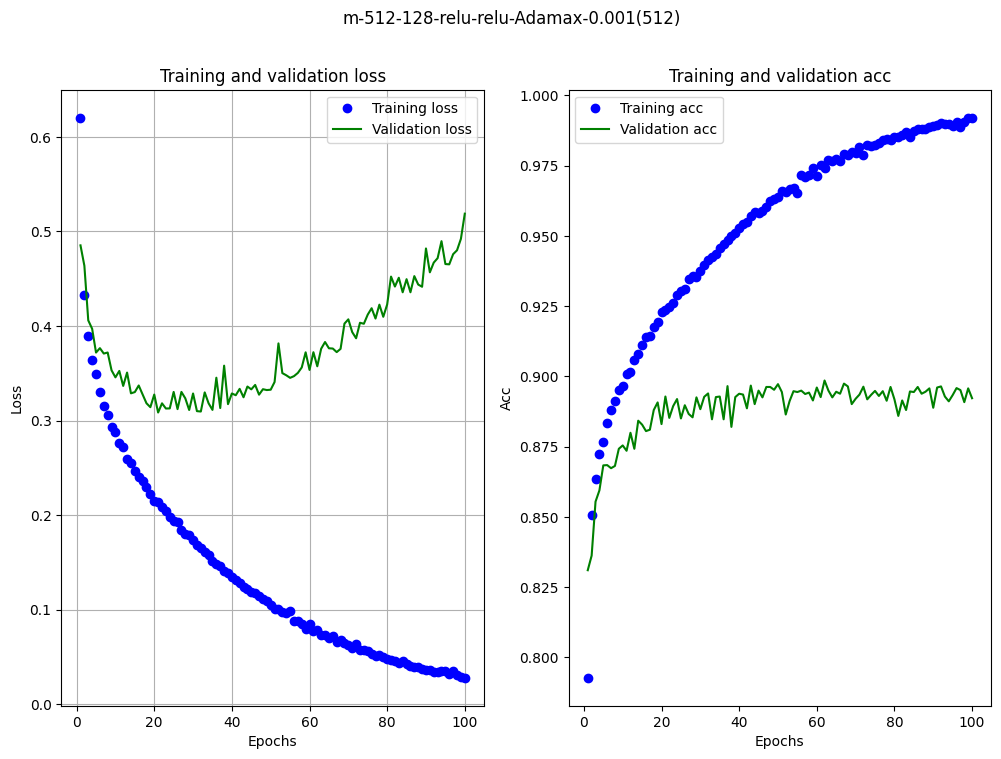

In [40]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 128, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adamax, 
          lr=0.001,
          bs=512,
          )

Epoch 1/100
30/30 [==============================] - 2s 47ms/step - loss: 2.2723 - accuracy: 0.2361 - categorical_accuracy: 0.2361 - val_loss: 2.1988 - val_accuracy: 0.4179 - val_categorical_accuracy: 0.4179
Epoch 2/100
30/30 [==============================] - 1s 44ms/step - loss: 2.1471 - accuracy: 0.4685 - categorical_accuracy: 0.4685 - val_loss: 2.0897 - val_accuracy: 0.5101 - val_categorical_accuracy: 0.5101
Epoch 3/100
30/30 [==============================] - 1s 44ms/step - loss: 2.0372 - accuracy: 0.5365 - categorical_accuracy: 0.5365 - val_loss: 1.9798 - val_accuracy: 0.5439 - val_categorical_accuracy: 0.5439
Epoch 4/100
30/30 [==============================] - 1s 44ms/step - loss: 1.9261 - accuracy: 0.5670 - categorical_accuracy: 0.5670 - val_loss: 1.8688 - val_accuracy: 0.6025 - val_categorical_accuracy: 0.6025
Epoch 5/100
30/30 [==============================] - 1s 44ms/step - loss: 1.8147 - accuracy: 0.6007 - categorical_accuracy: 0.6007 - val_loss: 1.7586 - val_accuracy: 0.

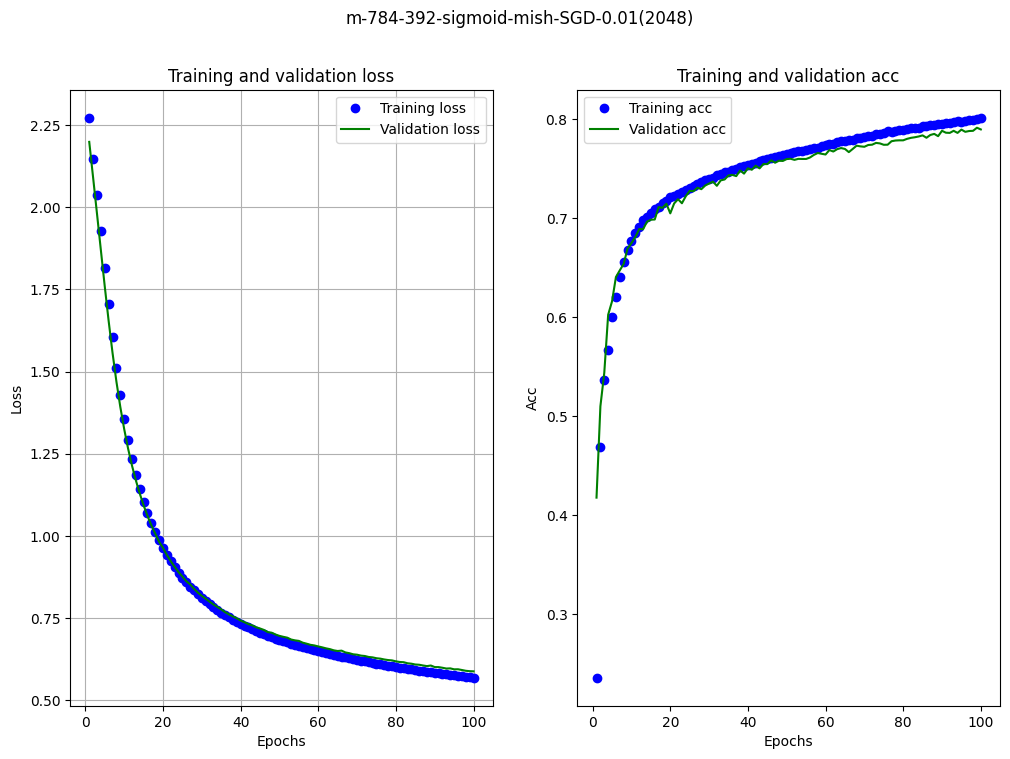

In [41]:
retest_NN(
          set_layers=[NUM_FEATURES, 784, 392, NUM_CLASSES], 
          act=['sigmoid', 'mish', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.01,
          bs=2048,
          )

Варіант 3:

Epoch 1/100
235/235 [==============================] - 2s 8ms/step - loss: 0.8542 - accuracy: 0.7766 - categorical_accuracy: 0.7766 - val_loss: 0.5726 - val_accuracy: 0.8320 - val_categorical_accuracy: 0.8320
Epoch 2/100
235/235 [==============================] - 2s 8ms/step - loss: 0.4754 - accuracy: 0.8540 - categorical_accuracy: 0.8540 - val_loss: 0.4730 - val_accuracy: 0.8402 - val_categorical_accuracy: 0.8402
Epoch 3/100
235/235 [==============================] - 2s 8ms/step - loss: 0.3914 - accuracy: 0.8724 - categorical_accuracy: 0.8724 - val_loss: 0.4295 - val_accuracy: 0.8478 - val_categorical_accuracy: 0.8478
Epoch 4/100
235/235 [==============================] - 2s 8ms/step - loss: 0.3494 - accuracy: 0.8812 - categorical_accuracy: 0.8812 - val_loss: 0.3883 - val_accuracy: 0.8649 - val_categorical_accuracy: 0.8649
Epoch 5/100
235/235 [==============================] - 2s 8ms/step - loss: 0.3204 - accuracy: 0.8902 - categorical_accuracy: 0.8902 - val_loss: 0.3695 - val_accurac

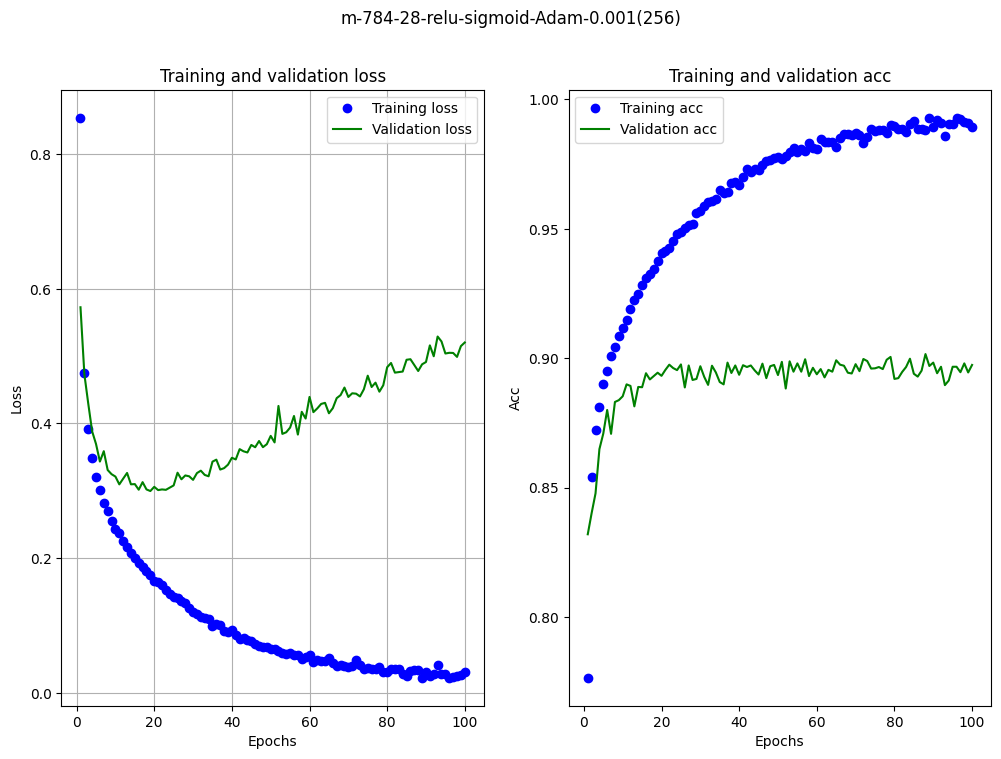

In [42]:
retest_NN(
          set_layers=[NUM_FEATURES, 784, 28, NUM_CLASSES], 
          act=['relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=256,
          )

Варіант 4:

Epoch 1/100
118/118 [==============================] - 2s 16ms/step - loss: 0.6844 - accuracy: 0.7723 - categorical_accuracy: 0.7723 - val_loss: 0.4806 - val_accuracy: 0.8299 - val_categorical_accuracy: 0.8299
Epoch 2/100
118/118 [==============================] - 2s 17ms/step - loss: 0.4168 - accuracy: 0.8511 - categorical_accuracy: 0.8511 - val_loss: 0.4376 - val_accuracy: 0.8438 - val_categorical_accuracy: 0.8438
Epoch 3/100
118/118 [==============================] - 2s 16ms/step - loss: 0.3734 - accuracy: 0.8650 - categorical_accuracy: 0.8650 - val_loss: 0.4460 - val_accuracy: 0.8316 - val_categorical_accuracy: 0.8316
Epoch 4/100
118/118 [==============================] - 2s 13ms/step - loss: 0.3475 - accuracy: 0.8738 - categorical_accuracy: 0.8738 - val_loss: 0.3812 - val_accuracy: 0.8662 - val_categorical_accuracy: 0.8662
Epoch 5/100
118/118 [==============================] - 2s 15ms/step - loss: 0.3276 - accuracy: 0.8818 - categorical_accuracy: 0.8818 - val_loss: 0.3615 - val_ac

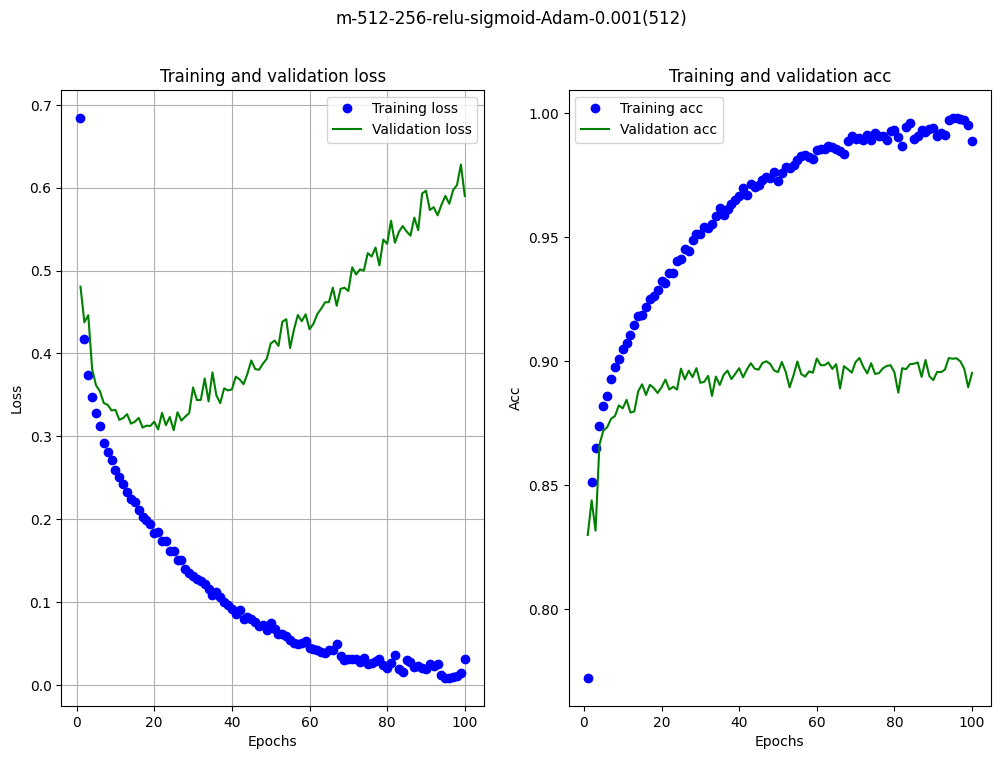

In [43]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 256, NUM_CLASSES], 
          act=['relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=512,
          )

Варіант 5:

Epoch 1/100
469/469 [==============================] - 3s 6ms/step - loss: 0.5135 - accuracy: 0.8192 - categorical_accuracy: 0.8192 - val_loss: 0.4095 - val_accuracy: 0.8528 - val_categorical_accuracy: 0.8528
Epoch 2/100
469/469 [==============================] - 3s 5ms/step - loss: 0.3588 - accuracy: 0.8693 - categorical_accuracy: 0.8693 - val_loss: 0.3672 - val_accuracy: 0.8694 - val_categorical_accuracy: 0.8694
Epoch 3/100
469/469 [==============================] - 2s 5ms/step - loss: 0.3237 - accuracy: 0.8814 - categorical_accuracy: 0.8814 - val_loss: 0.3489 - val_accuracy: 0.8734 - val_categorical_accuracy: 0.8734
Epoch 4/100
469/469 [==============================] - 3s 5ms/step - loss: 0.3002 - accuracy: 0.8889 - categorical_accuracy: 0.8889 - val_loss: 0.3578 - val_accuracy: 0.8717 - val_categorical_accuracy: 0.8717
Epoch 5/100
469/469 [==============================] - 3s 5ms/step - loss: 0.2784 - accuracy: 0.8975 - categorical_accuracy: 0.8975 - val_loss: 0.3411 - val_accurac

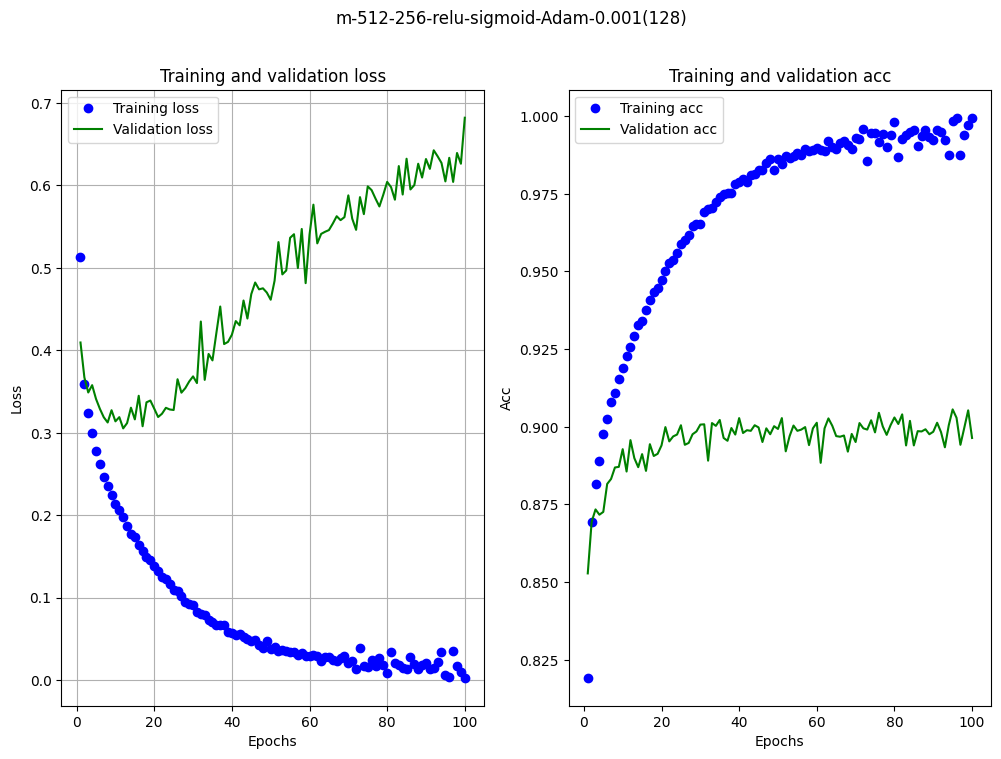

In [44]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 256, NUM_CLASSES], 
          act=['relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=128,
          )

Epoch 1/36
118/118 [==============================] - 9s 74ms/step - loss: 0.5387 - accuracy: 0.8093 - categorical_accuracy: 0.8093 - val_loss: 0.4355 - val_accuracy: 0.8428 - val_categorical_accuracy: 0.8428
Epoch 2/36
118/118 [==============================] - 9s 73ms/step - loss: 0.3636 - accuracy: 0.8702 - categorical_accuracy: 0.8702 - val_loss: 0.3937 - val_accuracy: 0.8597 - val_categorical_accuracy: 0.8597
Epoch 3/36
118/118 [==============================] - 9s 73ms/step - loss: 0.3243 - accuracy: 0.8835 - categorical_accuracy: 0.8835 - val_loss: 0.3554 - val_accuracy: 0.8699 - val_categorical_accuracy: 0.8699
Epoch 4/36
118/118 [==============================] - 9s 73ms/step - loss: 0.3021 - accuracy: 0.8910 - categorical_accuracy: 0.8910 - val_loss: 0.3518 - val_accuracy: 0.8726 - val_categorical_accuracy: 0.8726
Epoch 5/36
118/118 [==============================] - 9s 73ms/step - loss: 0.2785 - accuracy: 0.8986 - categorical_accuracy: 0.8986 - val_loss: 0.3424 - val_accurac

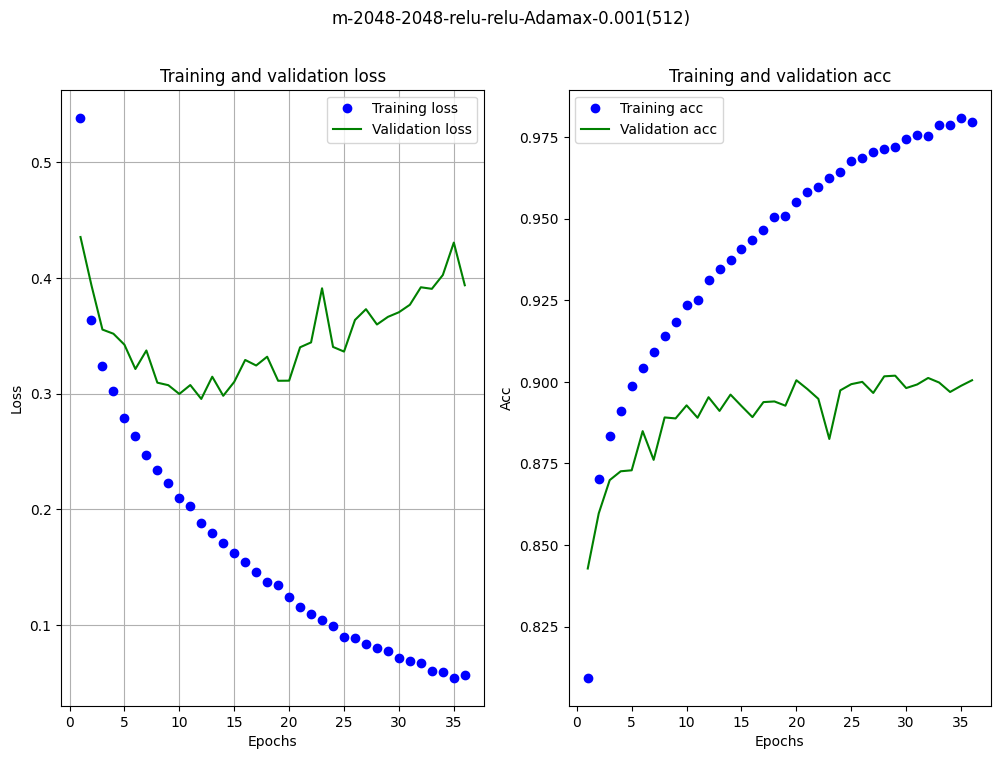

In [45]:
retest_NN(
          set_layers=[NUM_FEATURES, 2048, 2048, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adamax, 
          lr=0.001,
          bs=512,
          epochs=36
          )

Epoch 1/29
118/118 [==============================] - 2s 11ms/step - loss: 0.6311 - accuracy: 0.7854 - categorical_accuracy: 0.7854 - val_loss: 0.4918 - val_accuracy: 0.8279 - val_categorical_accuracy: 0.8279
Epoch 2/29
118/118 [==============================] - 1s 10ms/step - loss: 0.4362 - accuracy: 0.8493 - categorical_accuracy: 0.8493 - val_loss: 0.4502 - val_accuracy: 0.8443 - val_categorical_accuracy: 0.8443
Epoch 3/29
118/118 [==============================] - 1s 12ms/step - loss: 0.3989 - accuracy: 0.8606 - categorical_accuracy: 0.8606 - val_loss: 0.4147 - val_accuracy: 0.8546 - val_categorical_accuracy: 0.8546
Epoch 4/29
118/118 [==============================] - 1s 11ms/step - loss: 0.3726 - accuracy: 0.8690 - categorical_accuracy: 0.8690 - val_loss: 0.4134 - val_accuracy: 0.8563 - val_categorical_accuracy: 0.8563
Epoch 5/29
118/118 [==============================] - 1s 11ms/step - loss: 0.3527 - accuracy: 0.8764 - categorical_accuracy: 0.8764 - val_loss: 0.3824 - val_accurac

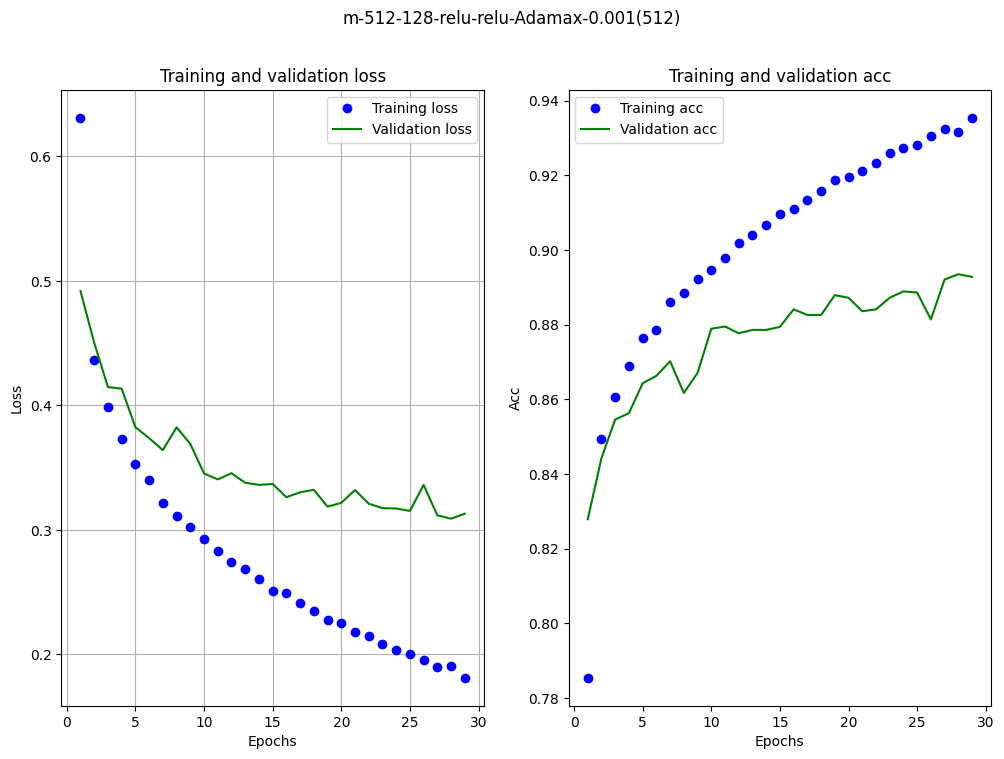

In [46]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, 128, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adamax, 
          lr=0.001,
          bs=512,
          epochs=29
          )

Epoch 1/100
118/118 [==============================] - 1s 9ms/step - loss: 0.5966 - accuracy: 0.7962 - categorical_accuracy: 0.7962 - val_loss: 0.4909 - val_accuracy: 0.8205 - val_categorical_accuracy: 0.8205
Epoch 2/100
118/118 [==============================] - 1s 11ms/step - loss: 0.4154 - accuracy: 0.8560 - categorical_accuracy: 0.8560 - val_loss: 0.4376 - val_accuracy: 0.8455 - val_categorical_accuracy: 0.8455
Epoch 3/100
118/118 [==============================] - 1s 9ms/step - loss: 0.3762 - accuracy: 0.8682 - categorical_accuracy: 0.8682 - val_loss: 0.4153 - val_accuracy: 0.8511 - val_categorical_accuracy: 0.8511
Epoch 4/100
118/118 [==============================] - 1s 9ms/step - loss: 0.3494 - accuracy: 0.8763 - categorical_accuracy: 0.8763 - val_loss: 0.3853 - val_accuracy: 0.8649 - val_categorical_accuracy: 0.8649
Epoch 5/100
118/118 [==============================] - 1s 8ms/step - loss: 0.3311 - accuracy: 0.8817 - categorical_accuracy: 0.8817 - val_loss: 0.3820 - val_accura

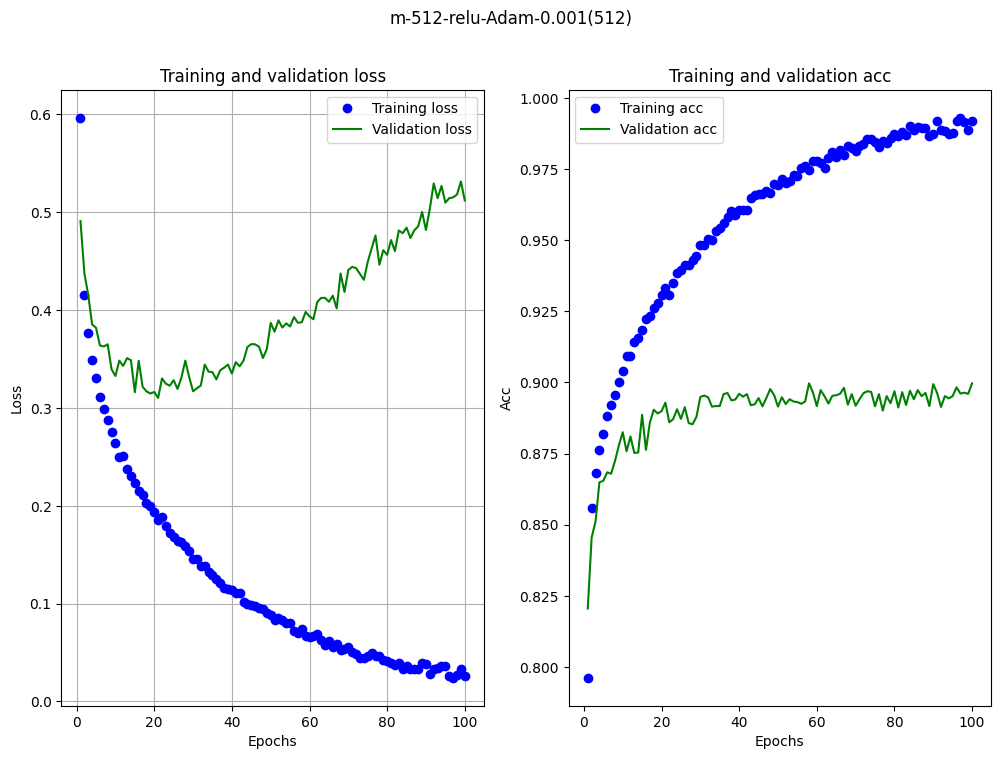

In [47]:
retest_NN(
          set_layers=[NUM_FEATURES, 512, NUM_CLASSES], 
          act=['relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=512,
          epochs=100
          )

Epoch 1/320
235/235 [==============================] - 1s 2ms/step - loss: 2.3774 - accuracy: 0.0329 - categorical_accuracy: 0.0329 - val_loss: 2.3554 - val_accuracy: 0.0500 - val_categorical_accuracy: 0.0500
Epoch 2/320
235/235 [==============================] - 0s 2ms/step - loss: 2.3419 - accuracy: 0.0665 - categorical_accuracy: 0.0665 - val_loss: 2.3310 - val_accuracy: 0.0755 - val_categorical_accuracy: 0.0755
Epoch 3/320
235/235 [==============================] - 0s 2ms/step - loss: 2.3216 - accuracy: 0.0861 - categorical_accuracy: 0.0861 - val_loss: 2.3138 - val_accuracy: 0.0886 - val_categorical_accuracy: 0.0886
Epoch 4/320
235/235 [==============================] - 0s 2ms/step - loss: 2.3058 - accuracy: 0.0991 - categorical_accuracy: 0.0991 - val_loss: 2.2995 - val_accuracy: 0.1025 - val_categorical_accuracy: 0.1025
Epoch 5/320
235/235 [==============================] - 0s 2ms/step - loss: 2.2923 - accuracy: 0.1151 - categorical_accuracy: 0.1151 - val_loss: 2.2867 - val_accurac

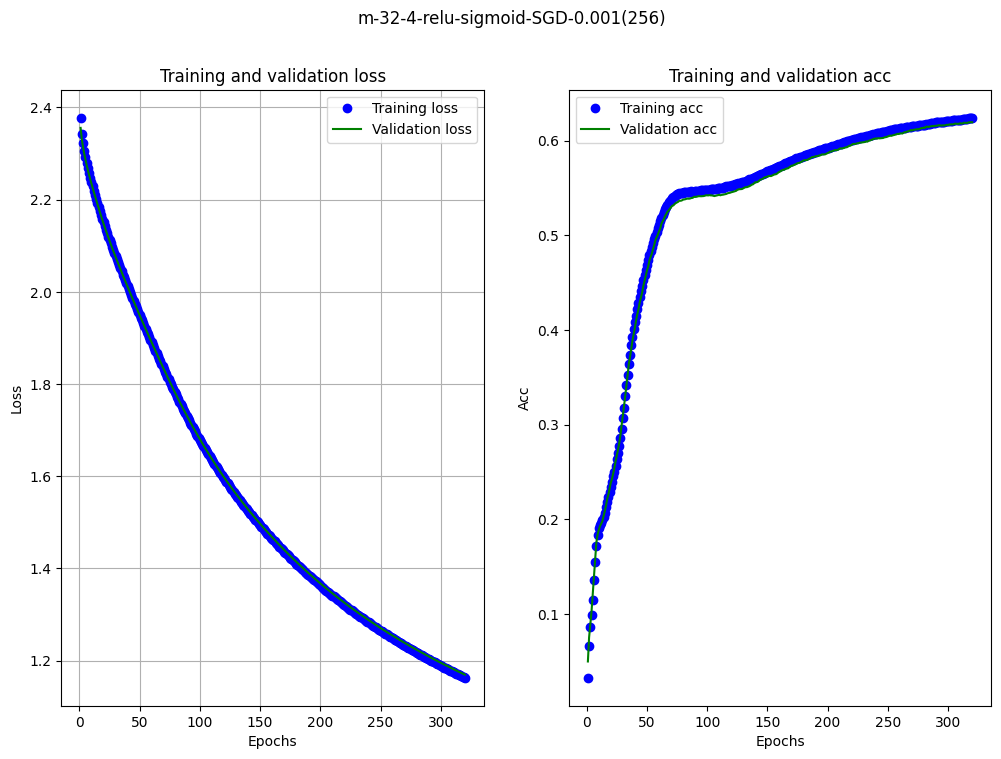

In [48]:
retest_NN(
          set_layers=[NUM_FEATURES, 32, 4, NUM_CLASSES], 
          act=['relu', 'sigmoid', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=256,
          epochs=320
          )

Epoch 1/200
118/118 [==============================] - 2s 13ms/step - loss: 0.5976 - accuracy: 0.7932 - categorical_accuracy: 0.7932 - val_loss: 0.4691 - val_accuracy: 0.8366 - val_categorical_accuracy: 0.8366
Epoch 2/200
118/118 [==============================] - 1s 13ms/step - loss: 0.3923 - accuracy: 0.8604 - categorical_accuracy: 0.8604 - val_loss: 0.4013 - val_accuracy: 0.8589 - val_categorical_accuracy: 0.8589
Epoch 3/200
118/118 [==============================] - 2s 13ms/step - loss: 0.3466 - accuracy: 0.8741 - categorical_accuracy: 0.8741 - val_loss: 0.3642 - val_accuracy: 0.8685 - val_categorical_accuracy: 0.8685
Epoch 4/200
118/118 [==============================] - 1s 12ms/step - loss: 0.3217 - accuracy: 0.8820 - categorical_accuracy: 0.8820 - val_loss: 0.3586 - val_accuracy: 0.8666 - val_categorical_accuracy: 0.8666
Epoch 5/200
118/118 [==============================] - 1s 12ms/step - loss: 0.2991 - accuracy: 0.8904 - categorical_accuracy: 0.8904 - val_loss: 0.3532 - val_ac

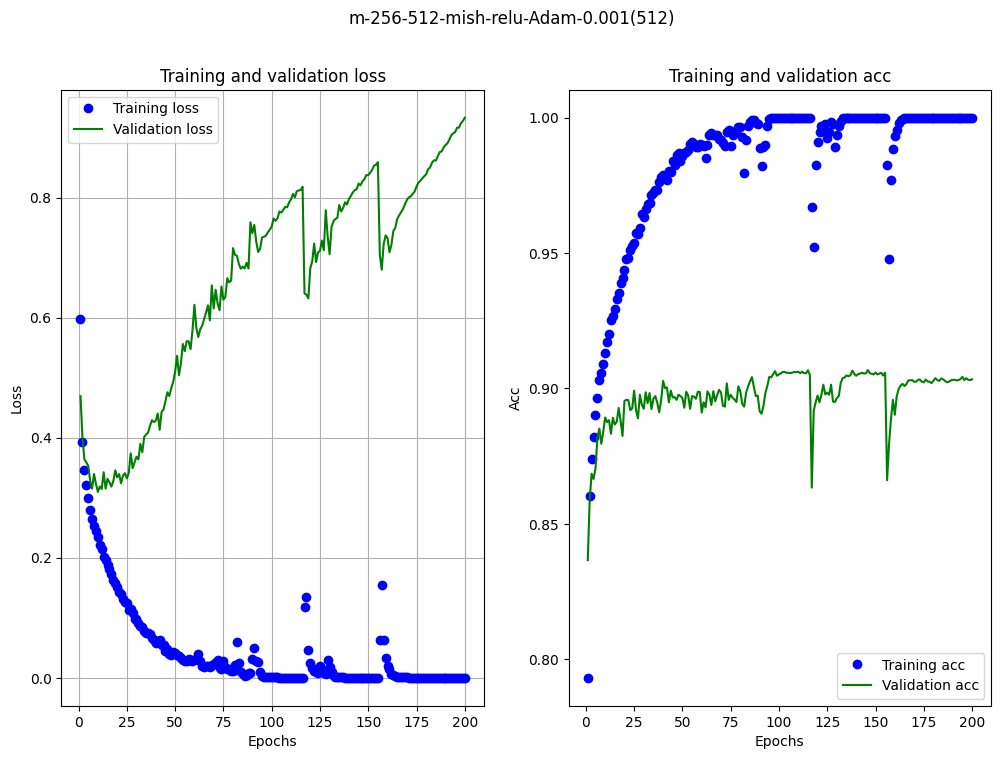

In [49]:
retest_NN(
          set_layers=[NUM_FEATURES, 256, 512, NUM_CLASSES], 
          act=['mish', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=512,
          epochs=200
          )

Epoch 1/300
118/118 [==============================] - 1s 11ms/step - loss: 2.3844 - accuracy: 0.0753 - categorical_accuracy: 0.0753 - val_loss: 2.3445 - val_accuracy: 0.0944 - val_categorical_accuracy: 0.0944
Epoch 2/300
118/118 [==============================] - 1s 10ms/step - loss: 2.3117 - accuracy: 0.1178 - categorical_accuracy: 0.1178 - val_loss: 2.2750 - val_accuracy: 0.1477 - val_categorical_accuracy: 0.1477
Epoch 3/300
118/118 [==============================] - 1s 8ms/step - loss: 2.2436 - accuracy: 0.1855 - categorical_accuracy: 0.1855 - val_loss: 2.2093 - val_accuracy: 0.2326 - val_categorical_accuracy: 0.2326
Epoch 4/300
118/118 [==============================] - 1s 10ms/step - loss: 2.1787 - accuracy: 0.2724 - categorical_accuracy: 0.2724 - val_loss: 2.1461 - val_accuracy: 0.3109 - val_categorical_accuracy: 0.3109
Epoch 5/300
118/118 [==============================] - 1s 9ms/step - loss: 2.1158 - accuracy: 0.3358 - categorical_accuracy: 0.3358 - val_loss: 2.0842 - val_accu

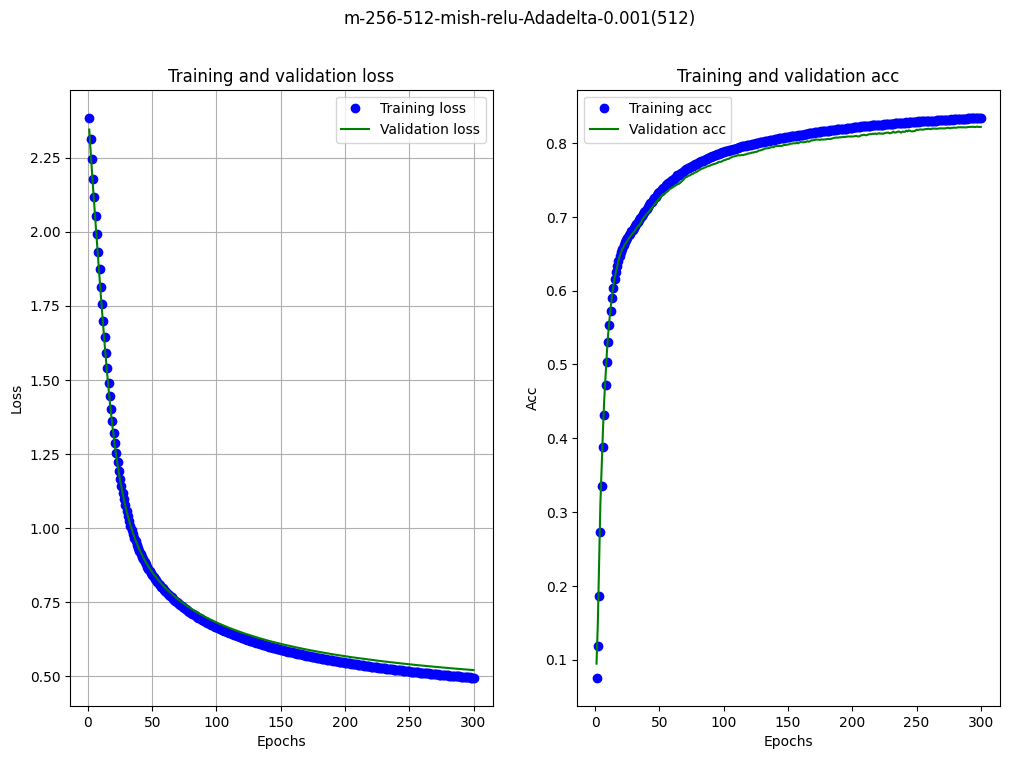

In [50]:
retest_NN(
          set_layers=[NUM_FEATURES, 256, 512, NUM_CLASSES], 
          act=['mish', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adadelta, 
          lr=0.001,
          bs=512,
          epochs=300  # 300
          )

Epoch 1/100
118/118 [==============================] - 1s 10ms/step - loss: 2.2905 - accuracy: 0.1628 - categorical_accuracy: 0.1628 - val_loss: 2.2556 - val_accuracy: 0.1930 - val_categorical_accuracy: 0.1930
Epoch 2/100
118/118 [==============================] - 1s 9ms/step - loss: 2.2244 - accuracy: 0.2066 - categorical_accuracy: 0.2066 - val_loss: 2.1900 - val_accuracy: 0.2285 - val_categorical_accuracy: 0.2285
Epoch 3/100
118/118 [==============================] - 1s 9ms/step - loss: 2.1587 - accuracy: 0.2472 - categorical_accuracy: 0.2472 - val_loss: 2.1249 - val_accuracy: 0.2738 - val_categorical_accuracy: 0.2738
Epoch 4/100
118/118 [==============================] - 1s 9ms/step - loss: 2.0933 - accuracy: 0.3102 - categorical_accuracy: 0.3102 - val_loss: 2.0602 - val_accuracy: 0.3520 - val_categorical_accuracy: 0.3520
Epoch 5/100
118/118 [==============================] - 1s 9ms/step - loss: 2.0284 - accuracy: 0.4013 - categorical_accuracy: 0.4013 - val_loss: 1.9960 - val_accura

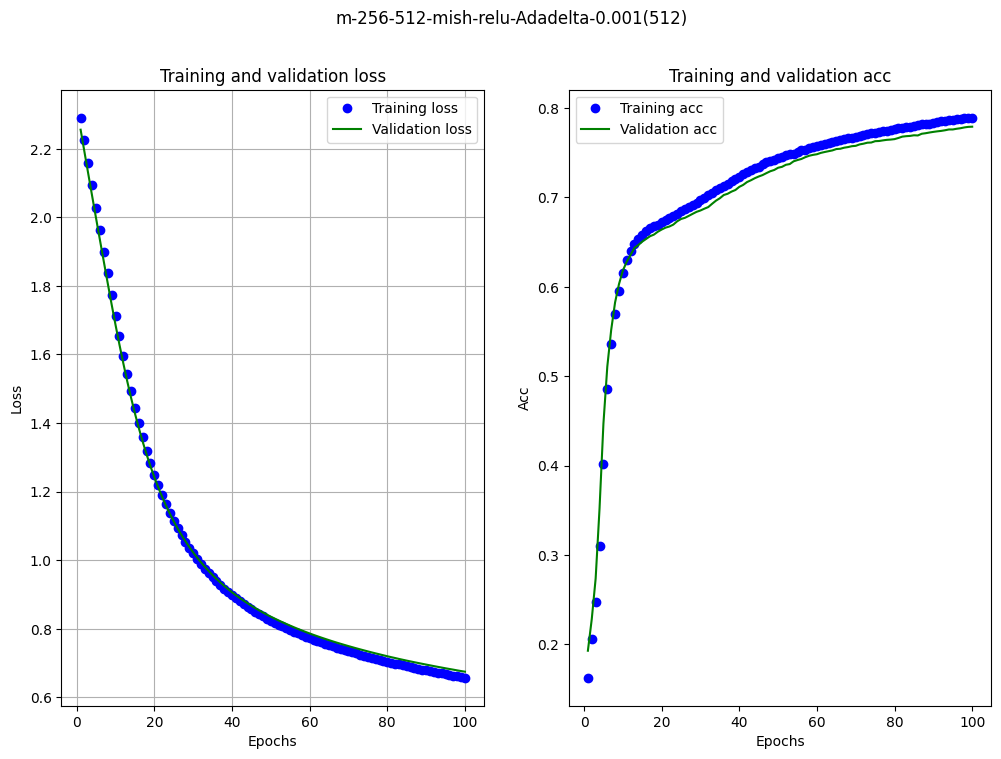

In [51]:
retest_NN(
          set_layers=[NUM_FEATURES, 256, 512, NUM_CLASSES], 
          act=['mish', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adadelta, 
          lr=0.001,
          bs=512,
          epochs=100  # 300
          )

Epoch 1/100
118/118 [==============================] - 1s 8ms/step - loss: 0.6540 - accuracy: 0.7796 - categorical_accuracy: 0.7796 - val_loss: 0.4740 - val_accuracy: 0.8345 - val_categorical_accuracy: 0.8345
Epoch 2/100
118/118 [==============================] - 1s 7ms/step - loss: 0.4179 - accuracy: 0.8541 - categorical_accuracy: 0.8541 - val_loss: 0.4542 - val_accuracy: 0.8386 - val_categorical_accuracy: 0.8386
Epoch 3/100
118/118 [==============================] - 1s 10ms/step - loss: 0.3784 - accuracy: 0.8668 - categorical_accuracy: 0.8668 - val_loss: 0.4339 - val_accuracy: 0.8478 - val_categorical_accuracy: 0.8478
Epoch 4/100
118/118 [==============================] - 1s 8ms/step - loss: 0.3529 - accuracy: 0.8738 - categorical_accuracy: 0.8738 - val_loss: 0.4155 - val_accuracy: 0.8517 - val_categorical_accuracy: 0.8517
Epoch 5/100
118/118 [==============================] - 1s 8ms/step - loss: 0.3305 - accuracy: 0.8820 - categorical_accuracy: 0.8820 - val_loss: 0.3658 - val_accura

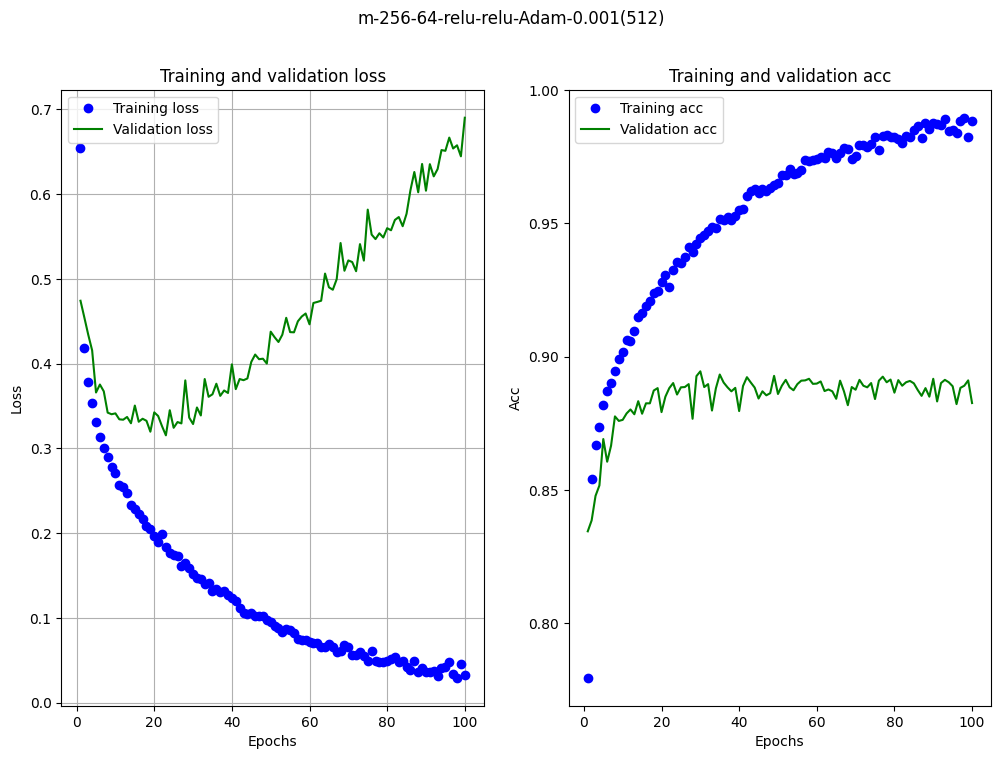

In [53]:
retest_NN(
          set_layers=[NUM_FEATURES, 256, 64, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=512,
          epochs=100  
          )

Epoch 1/100
118/118 [==============================] - 1s 8ms/step - loss: 2.2628 - accuracy: 0.1632 - categorical_accuracy: 0.1632 - val_loss: 2.1442 - val_accuracy: 0.2469 - val_categorical_accuracy: 0.2469
Epoch 2/100
118/118 [==============================] - 1s 6ms/step - loss: 2.0590 - accuracy: 0.2966 - categorical_accuracy: 0.2966 - val_loss: 1.9765 - val_accuracy: 0.3582 - val_categorical_accuracy: 0.3582
Epoch 3/100
118/118 [==============================] - 1s 8ms/step - loss: 1.9044 - accuracy: 0.4055 - categorical_accuracy: 0.4055 - val_loss: 1.8359 - val_accuracy: 0.4539 - val_categorical_accuracy: 0.4539
Epoch 4/100
118/118 [==============================] - 1s 9ms/step - loss: 1.7716 - accuracy: 0.4872 - categorical_accuracy: 0.4872 - val_loss: 1.7133 - val_accuracy: 0.5212 - val_categorical_accuracy: 0.5212
Epoch 5/100
118/118 [==============================] - 1s 9ms/step - loss: 1.6538 - accuracy: 0.5659 - categorical_accuracy: 0.5659 - val_loss: 1.6033 - val_accurac

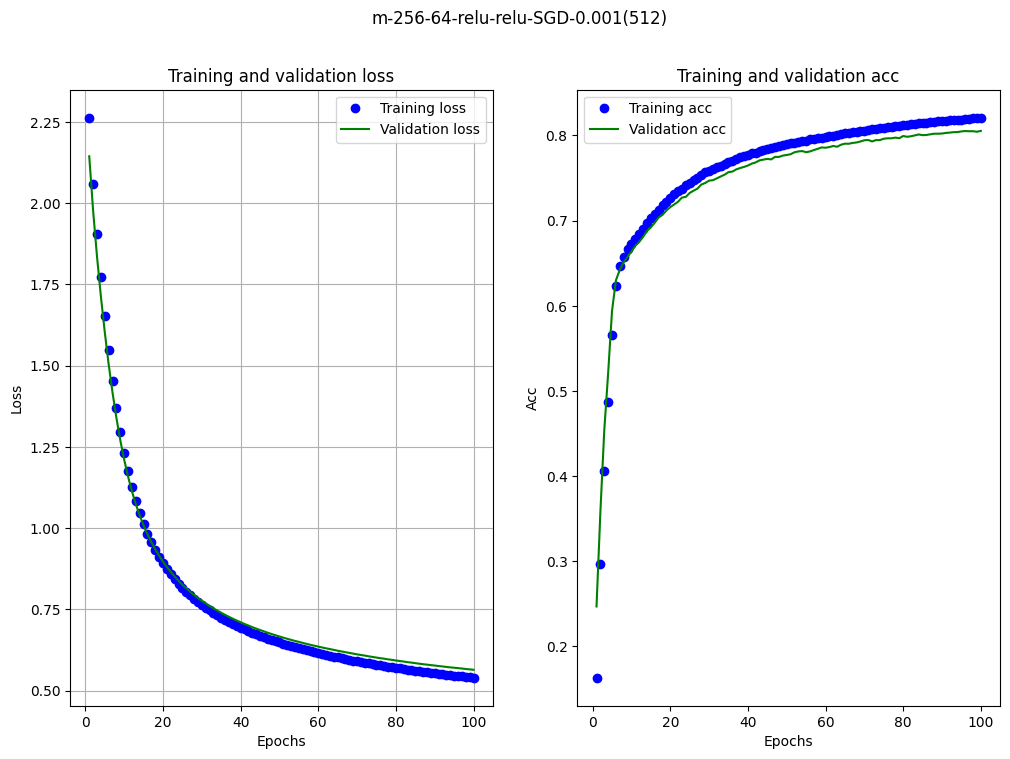

In [54]:
retest_NN(
          set_layers=[NUM_FEATURES, 256, 64, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.SGD, 
          lr=0.001,
          bs=512,
          epochs=100  
          )

Epoch 1/100
118/118 [==============================] - 1s 8ms/step - loss: 0.7497 - accuracy: 0.7383 - categorical_accuracy: 0.7383 - val_loss: 0.5666 - val_accuracy: 0.7949 - val_categorical_accuracy: 0.7949
Epoch 2/100
118/118 [==============================] - 1s 6ms/step - loss: 0.4713 - accuracy: 0.8290 - categorical_accuracy: 0.8290 - val_loss: 0.5540 - val_accuracy: 0.7911 - val_categorical_accuracy: 0.7911
Epoch 3/100
118/118 [==============================] - 1s 6ms/step - loss: 0.4079 - accuracy: 0.8510 - categorical_accuracy: 0.8510 - val_loss: 0.5601 - val_accuracy: 0.7792 - val_categorical_accuracy: 0.7792
Epoch 4/100
118/118 [==============================] - 1s 6ms/step - loss: 0.3706 - accuracy: 0.8635 - categorical_accuracy: 0.8635 - val_loss: 0.4177 - val_accuracy: 0.8484 - val_categorical_accuracy: 0.8484
Epoch 5/100
118/118 [==============================] - 1s 6ms/step - loss: 0.3437 - accuracy: 0.8740 - categorical_accuracy: 0.8740 - val_loss: 0.4268 - val_accurac

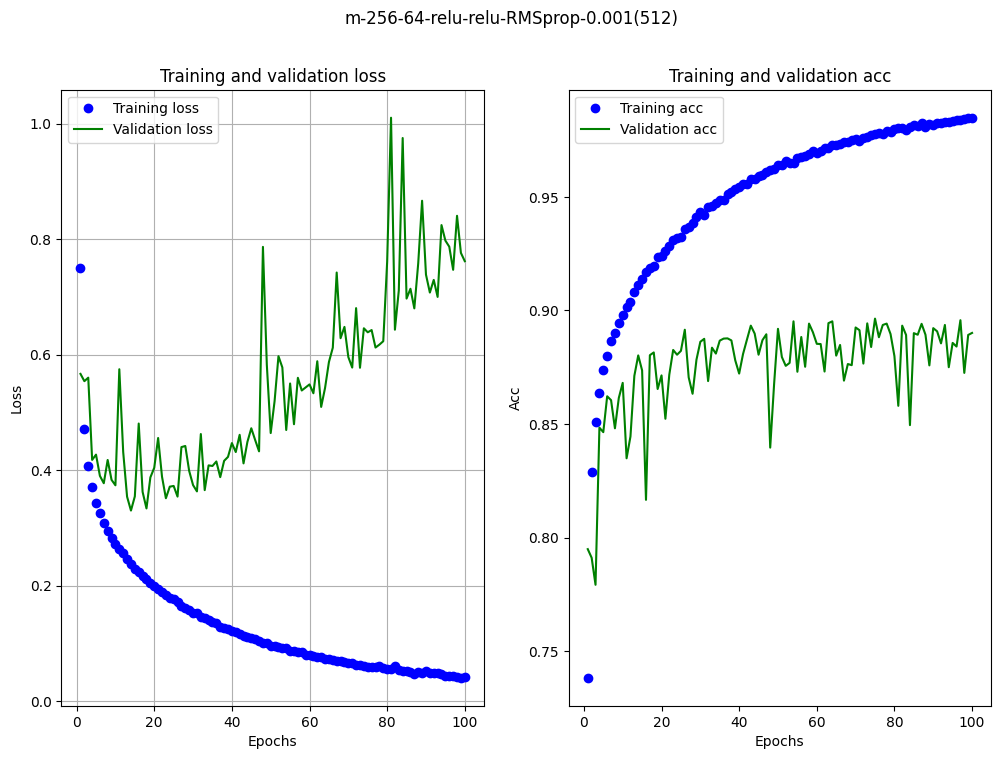

In [55]:
retest_NN(
          set_layers=[NUM_FEATURES, 256, 64, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.RMSprop, 
          lr=0.001,
          bs=512,
          epochs=100  
          )

In [61]:
def retest_repNN(set_layers: list, act: list, opt: optimizers, lr: float, bs: int, epochs: int=100) -> None:
    """For retest one model."""
    models = [create_NN(
                        n_hidden_=set_layers, 
                        activation=act, 
                        optimizer=opt, 
                        learning_rate=lr
                        ) for _ in range(5)] 

    history = {}
    for i, model in enumerate(models):
        history[f'{i}-{models[i].name}({bs})'] = model.fit(
                                                        x_train,
                                                        y_true,
                                                        epochs=epochs,
                                                        batch_size=bs,
                                                        validation_data=(x_test, y_truev)
                                                        )

    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    for model in history:
        history_dict = history[model].history

        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        acc_values = history_dict['categorical_accuracy']
        val_acc_values = history_dict['val_categorical_accuracy']   

        y00 = loss_values
        y01 = val_loss_values
        y10 = acc_values
        y11 = val_acc_values
        suptitle = model
        
        x = range(1, len(y00) + 1)

        axs[0].plot(x, y00, 'bo', label='Training loss')
        axs[0].plot(x, y01, 'g', label='Validation loss')
        axs[0].title.set_text('Training and validation loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[0].grid()

        axs[1].plot(x, y10, 'bo', label='Training acc')
        axs[1].plot(x, y11, 'g', label='Validation acc')
        axs[1].title.set_text('Training and validation acc')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Acc')
        axs[1].legend()
        axs[1].grid()
        
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    axs[1].grid()
    plt.show()

Epoch 1/100
59/59 [==============================] - 1s 14ms/step - loss: 0.8084 - accuracy: 0.7282 - categorical_accuracy: 0.7282 - val_loss: 0.5391 - val_accuracy: 0.8122 - val_categorical_accuracy: 0.8122
Epoch 2/100
59/59 [==============================] - 1s 12ms/step - loss: 0.4692 - accuracy: 0.8390 - categorical_accuracy: 0.8390 - val_loss: 0.4659 - val_accuracy: 0.8398 - val_categorical_accuracy: 0.8398
Epoch 3/100
59/59 [==============================] - 1s 13ms/step - loss: 0.4134 - accuracy: 0.8573 - categorical_accuracy: 0.8573 - val_loss: 0.4273 - val_accuracy: 0.8485 - val_categorical_accuracy: 0.8485
Epoch 4/100
59/59 [==============================] - 1s 13ms/step - loss: 0.3843 - accuracy: 0.8658 - categorical_accuracy: 0.8658 - val_loss: 0.4090 - val_accuracy: 0.8557 - val_categorical_accuracy: 0.8557
Epoch 5/100
59/59 [==============================] - 1s 15ms/step - loss: 0.3569 - accuracy: 0.8734 - categorical_accuracy: 0.8734 - val_loss: 0.3903 - val_accuracy: 0.

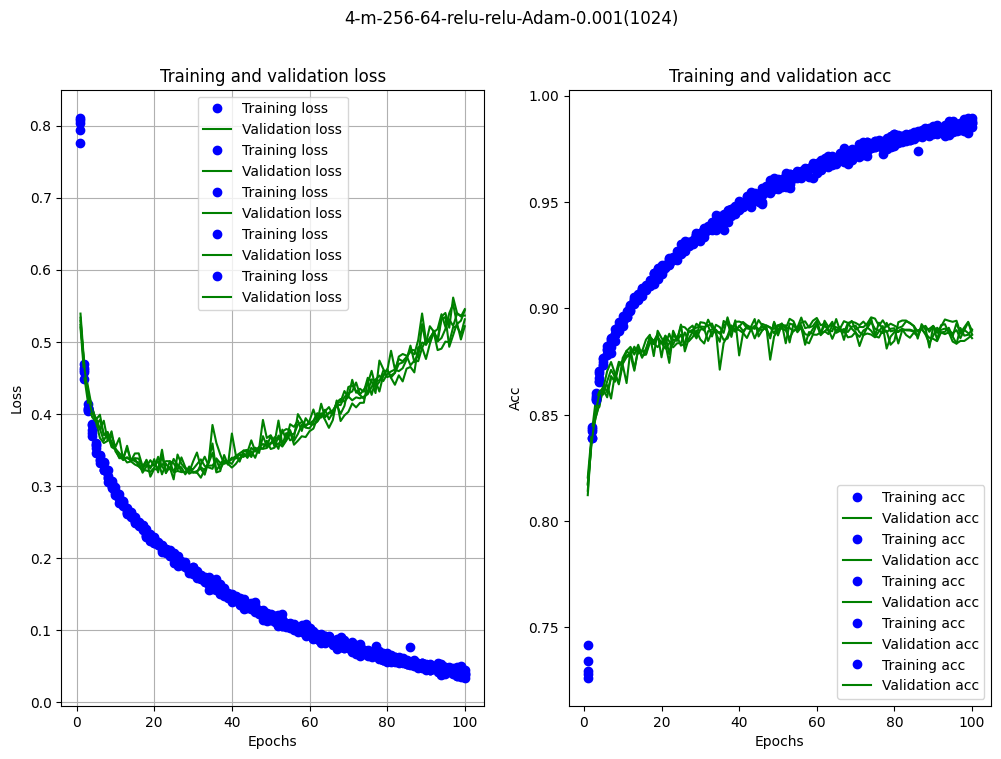

In [63]:
retest_repNN(
          set_layers=[NUM_FEATURES, 256, 64, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=1024,
          epochs=100 
          )

test set_seed...

In [66]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(1)

In [71]:
def retest_repNNrf(set_layers: list, act: list, opt: optimizers, lr: float, bs: int, epochs: int=100) -> None:
    """For retest one model."""
    models = [create_NN(
                        n_hidden_=set_layers, 
                        activation=act, 
                        optimizer=opt, 
                        learning_rate=lr
                        ) for _ in range(5) if not set_seed(1)] 

    history = {}
    for i, model in enumerate(models):
        set_seed(1)
        history[f'{i}-{models[i].name}({bs})'] = model.fit(
                                                        x_train,
                                                        y_true,
                                                        epochs=epochs,
                                                        batch_size=bs,
                                                        validation_data=(x_test, y_truev)
                                                        )

    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    for model in history:
        history_dict = history[model].history

        loss_values = history_dict['loss']
        val_loss_values = history_dict['val_loss']
        acc_values = history_dict['categorical_accuracy']
        val_acc_values = history_dict['val_categorical_accuracy']   

        y00 = loss_values
        y01 = val_loss_values
        y10 = acc_values
        y11 = val_acc_values
        suptitle = model
        
        x = range(1, len(y00) + 1)

        axs[0].plot(x, y00, 'bo', label='Training loss')
        axs[0].plot(x, y01, 'g', label='Validation loss')
        axs[0].title.set_text('Training and validation loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[0].grid()

        axs[1].plot(x, y10, 'bo', label='Training acc')
        axs[1].plot(x, y11, 'g', label='Validation acc')
        axs[1].title.set_text('Training and validation acc')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Acc')
        axs[1].legend()
        axs[1].grid()
        
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    axs[1].grid()
    plt.show()

Epoch 1/100
59/59 [==============================] - 1s 12ms/step - loss: 0.7919 - accuracy: 0.7316 - categorical_accuracy: 0.7316 - val_loss: 0.5259 - val_accuracy: 0.8167 - val_categorical_accuracy: 0.8167
Epoch 2/100
59/59 [==============================] - 1s 11ms/step - loss: 0.4636 - accuracy: 0.8388 - categorical_accuracy: 0.8388 - val_loss: 0.4658 - val_accuracy: 0.8347 - val_categorical_accuracy: 0.8347
Epoch 3/100
59/59 [==============================] - 1s 11ms/step - loss: 0.4166 - accuracy: 0.8536 - categorical_accuracy: 0.8536 - val_loss: 0.4297 - val_accuracy: 0.8471 - val_categorical_accuracy: 0.8471
Epoch 4/100
59/59 [==============================] - 1s 14ms/step - loss: 0.3778 - accuracy: 0.8671 - categorical_accuracy: 0.8671 - val_loss: 0.4132 - val_accuracy: 0.8523 - val_categorical_accuracy: 0.8523
Epoch 5/100
59/59 [==============================] - 1s 14ms/step - loss: 0.3617 - accuracy: 0.8720 - categorical_accuracy: 0.8720 - val_loss: 0.3908 - val_accuracy: 0.

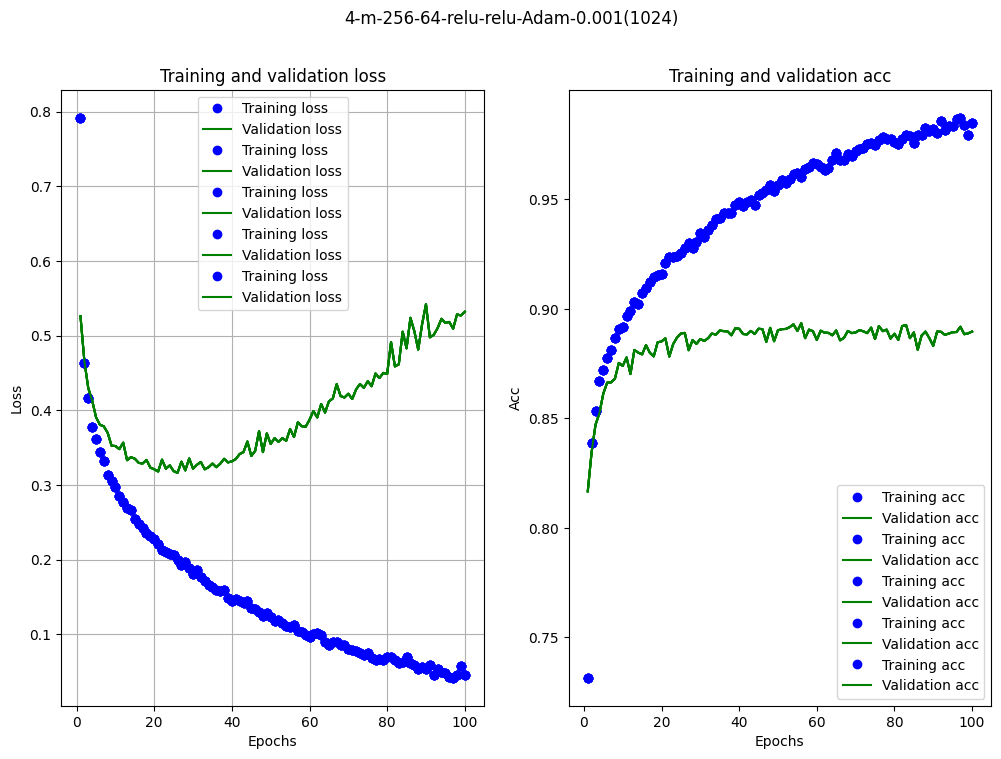

In [72]:
retest_repNNrf(
          set_layers=[NUM_FEATURES, 256, 64, NUM_CLASSES], 
          act=['relu', 'relu', 'softmax'], 
          opt=optimizers.legacy.Adam, 
          lr=0.001,
          bs=1024,
          epochs=100 
          )